# Исследование рыночной стоимости автомобилей<a class="tocSkip">
<a id="start"></a>

<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Признаки-типа-datetime" data-toc-modified-id="Признаки-типа-datetime-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Признаки типа datetime</a></span></li><li><span><a href="#Численные-признаки" data-toc-modified-id="Численные-признаки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Численные признаки</a></span></li><li><span><a href="#Категориальные-признаки" data-toc-modified-id="Категориальные-признаки-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Категориальные признаки</a></span></li><li><span><a href="#Добавление-новых-признаков" data-toc-modified-id="Добавление-новых-признаков-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Добавление новых признаков</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Оценка-качества" data-toc-modified-id="Оценка-качества-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Оценка качества</a></span><ul class="toc-item"><li><span><a href="#Анализ-остатков" data-toc-modified-id="Анализ-остатков-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Анализ остатков</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Описание проекта

### Записка к данным<a class="tocSkip">

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:
* качество предсказания;
* скорость предсказания;
* время обучения.
___

Перед началом анализа импортируем необходимые библиотеки и создадим несколько функций.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import datetime
import time
from numpy.polynomial.polynomial import polyfit

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, cross_validate

from sklearn.metrics import r2_score, mean_squared_error, max_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle

from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_columns = None
%matplotlib inline

In [3]:
def check_split(train_data, test_data, cat_features):
    train = train_data.copy().replace(np.nan, 'None')
    test = test_data.copy().replace(np.nan, 'None')
    train['is_train'] = 1
    test['is_train'] = 0
    data = pd.concat([train, test], axis=0, ignore_index=True)
    data = shuffle(data, random_state=42)
    x = data.drop(columns=['is_train'])
    y = data['is_train']
    clf = CatBoostClassifier(random_state=42, cat_features=cat_features, iterations=50, verbose=False)
    score = cross_val_score(clf, x, y, cv=3, scoring='roc_auc').mean()
    return score

In [4]:
def test_hypothesis(x, y=None, stat='ttest', alpha=0.05):
    if stat == 'ttest':
        p = st.ttest_ind(x, y, equal_var=False).pvalue
    elif stat == 'mannwhitneyu':
        p = st.mannwhitneyu(x, y, alternative='two-sided').pvalue
    elif stat == 'chi2':
        _, p, _, _ = st.chi2_contingency(x)
        
    print('p-value: {:.2g}'.format(p))    
    if (p < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
    return

In [5]:
def plot_distribution(data_list, xlabels, title=None, kind='hist', bins=None, rotate_text=False, figsize=(15,6)):
    if kind == 'hist':
        fig, axes = plt.subplots(
            nrows=2, ncols=len(data_list), figsize=figsize, gridspec_kw={'height_ratios': [1, 4]}
        )
    else: fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)    
    plt.subplots_adjust(wspace=0.3, hspace=0)
    if title:
        plt.suptitle(title, fontsize=16)
    
    for i in range(len(data_list)):             
        if kind == 'hist':
            axes[0][i].set_facecolor('whitesmoke')
            axes[1][i].set_facecolor('whitesmoke')
               
            bottom_side = axes[0][i].spines['bottom']
            top_side = axes[1][i].spines['top']
            bottom_side.set_visible(False)
            top_side.set_visible(False)
            
            data_list[i].plot.hist(ax=axes[1][i], bins=bins[i], color='tomato', edgecolor='indianred', linewidth=2)
            axes[0][i].boxplot(
                data_list[i].dropna(), vert=False, patch_artist=True, notch=False, widths=0.3,
                boxprops=dict(facecolor='salmon', color='whitesmoke', lw=2),
                medianprops=dict(color='whitesmoke', lw=2),
                flierprops=dict(marker='o', markersize=10, markerfacecolor='whitesmoke', markeredgecolor='tomato'),
                whiskerprops=dict(color='salmon', lw=2),
                capprops=dict(lw=0)
            )
            axes[1][i].set_xlabel(xlabels[i], fontsize=14)
            axes[1][i].set_ylabel('Число объектов', fontsize=12)
            axes[0][i].set_xticks([])
            axes[0][i].set_yticks([])
            axes[1][i].grid(color='w', lw=1, axis='y')
            axes[1][i].set_axisbelow(True) 
            axes[1][i].yaxis.set_ticks_position('none') 
            
        elif kind == 'bar':
            axes[i].set_facecolor('whitesmoke')
            values = data_list[i].value_counts().sort_index()
            values.plot.bar(
                ax=axes[i], color='tomato', edgecolor='indianred', linewidth=2
            )
            k = 0
            if rotate_text:
                angle = 90
                axes[i].set_ylim(0, values.max() * 1.4)
                
            else:
                angle=0
                axes[i].set_ylim(0, values.max() * 1.2)
            for v in values:
                axes[i].text(k, v + 0.1 * values.max(), str(v), ha='center', 
                             fontsize=12,color='dimgrey', rotation=angle)
                k += 1
            axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0)
            
            axes[i].grid(color='w', lw=1, axis='y')
            axes[i].set_axisbelow(True)
            axes[i].xaxis.set_ticks_position('none')
            axes[i].yaxis.set_ticks_position('none')
            axes[i].set_xlabel(xlabels[i], fontsize=14)
            axes[i].set_ylabel('Число объектов', fontsize=12)
    plt.show()

In [6]:
def plot_corr_matrix(data, mask=False, figsize=(15,15)):
    size = len(data)
    if mask: 
        mask = np.triu(np.ones((size, size)), k=1)
    else: 
        mask = np.zeros((size, size))    
    fig, axes = plt.subplots(figsize=figsize)
    axes = sns.heatmap(data, annot=True, fmt='.2f', mask=mask, square=False)
    axes.set_title('Корреляционная матрица', fontsize=16, pad=20)
    axes.set_yticklabels(axes.get_yticklabels(), rotation=0)
    b, t = plt.ylim() 
    plt.ylim(b + 0.5, t - 0.5)
    plt.show()

In [7]:
def plot_scatter(data_list, xlabels, ylabels, title, alphas=[0.1,0.1,0.1], figsize=(15,6)):
    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)    
    plt.subplots_adjust(wspace=0.4)
    plt.suptitle(title, fontsize=16)    
    for i in range(len(data_list)):             
        axes[i].set_facecolor('whitesmoke')
        
        x = np.array(data_list[i].dropna().iloc[:, 0])
        y = np.array(data_list[i].dropna().iloc[:, 1])
        intercept, slope = polyfit(x, y, 1)
        right, left, top, bottom = max(x), min(x), max(y), min(y)
        axes[i].scatter(x, y, alpha=alphas[i], s=70, label='Выборка', marker="X", facecolor='tomato', 
                        edgecolors='tomato')
        axes[i].plot((left - (right-left)/20, right + (right-left)/20), 
                     (intercept + slope*(left - (right-left)/20), intercept + slope*(right + (right-left)/20)), 
                     '-', label='Аппроксимация', color='firebrick', lw=4)
        
        axes[i].set_xlabel(xlabels[i], fontsize=14)
        axes[i].set_ylabel(ylabels[i], fontsize=14)   
        axes[i].legend(facecolor='ghostwhite', title_fontsize=12, ncol=1, shadow=True, fancybox=False)
        axes[i].set_xlim(left - (right-left)/20, right + (right-left)/20)
        axes[i].set_ylim(bottom - (top-bottom)/20, top + (top-bottom)/20)
        
        axes[i].grid(color='w', lw=1, axis='both')
        axes[i].set_axisbelow(True)
        axes[i].xaxis.set_ticks_position('none')
        axes[i].yaxis.set_ticks_position('none')
    plt.show()

In [8]:
def plot_box(data_list, labels, ticks, title, figsize=(15,6)):    
    fig, axes = plt.subplots(figsize=figsize)    
    plt.subplots_adjust(wspace=0.3, hspace=0)
    plt.suptitle(title, fontsize=16)
    axes.set_facecolor('whitesmoke')
    axes.boxplot(
        data_list, vert=False, patch_artist=True, notch=False,
        boxprops=dict(facecolor='tomato', color='whitesmoke', lw=2),
        medianprops=dict(color='whitesmoke', lw=2),
        flierprops=dict(marker='o', markersize=15, markerfacecolor='whitesmoke', markeredgecolor='tomato'),
        whiskerprops=dict(color='orangered', lw=2),
        capprops=dict(lw=0)
    )        
    axes.set_xlabel(labels[0], fontsize=14)
    axes.set_ylabel(labels[1], fontsize=14)
    axes.grid(color='w', lw=1, axis='x')
    axes.set_yticklabels(ticks, fontsize=12)
    axes.xaxis.set_ticks_position('none')
    axes.yaxis.set_ticks_position('none')
    plt.show()
    return

In [9]:
def plot_line(x, y, xlabel, ylabel, title, xlim=(), ylim=(), figsize=(10,5)):
    fig, axes = plt.subplots(figsize=figsize)
    axes.set_facecolor('whitesmoke')
    axes.plot(x, y, linewidth=4, color='tomato')
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    axes.set_title(title, fontsize=16, pad=20)
    axes.set_xlabel(xlabel, fontsize=14)
    axes.set_ylabel(ylabel, fontsize=14)
    axes.grid(color='w', lw=1, axis='y')
    axes.yaxis.set_ticks_position('none')
    plt.show()

In [10]:
def plot_true_pred(true, pred, n=50, label='Обученная модель', figsize=(7,5)):
    target_df = pd.DataFrame({'true': true, 'pred': pred})
    target_df['true'] = pd.qcut(target_df['true'], q=n)
    target_df['true'] = target_df['true'].apply(lambda interval: (interval.right + interval.left) / 2)
    mean = target_df.groupby('true')['pred'].median()
    error = target_df.groupby('true')['pred'].std()
    
    fig, axes = plt.subplots(figsize=figsize)
    axes.set_facecolor('whitesmoke')
    axes.plot((mean.min(), mean.max()), (mean.min(), mean.max()), color='lightsalmon',
              lw=3, label='Идеальная модель')  
    axes.plot(np.array(mean.index), mean.values,'-', color='firebrick', linewidth=4, label=label)
      
    axes.fill_between(np.array(mean.index), (mean - error).values, (mean + error).values, 
                      color='tomato', label='Интервал $\mu\pm\sigma$')
    axes.set_title('Предсказания модели для автомобилей разной стоимости', fontsize=16, pad=20)
    axes.set_xlim(mean.min(), mean.max())
    axes.set_xlabel('Цена автомобиля, евро', fontsize=14)
    axes.set_ylabel('Предсказание модели, евро', fontsize=14)
    axes.grid(color='w', lw=1, axis='both')
    axes.set_axisbelow(True)
    axes.xaxis.set_ticks_position('none')
    axes.yaxis.set_ticks_position('none')
    axes.legend(facecolor='ghostwhite', title_fontsize=12, ncol=1, shadow=True, fancybox=False)
    plt.show()

In [11]:
class SGDLinearRegression(BaseEstimator):
    """ Линейная регрессия на основе стохастического градиентного спуска """
    def __init__(self, eta=1e-3, batch_size=100, max_iter=10, tol=1., n_iter_no_change=5, penalty='l2', alpha=1.0):
        """
        - eta : float, default=1e-3
            Шаг градиентного спуска
        - batch_size : int, default=100
            Размер батча
        - max_iter : int, default=10
            Максимальное число итераций (эпох)
        - tol : float, default=1.0
            Условие сходимости (если разность значений функции потерь на текущем и предущем шаге меньше, 
            чем tol, в течение последних n_iter_no_change эпох, оптимизация считается завершённой)
        - n_iter_no_change : int, default=5
            Условие сходимости (если разность значений функции потерь на текущем и предущем шаге меньше, 
            чем tol, в течение последних n_iter_no_change эпох, оптимизация считается завершённой)
        - penalty : {'l1', 'l2'}, default='l2'
            Тип регуляризации
        - alpha : float, default=1.0
            Коэффициент регуляризации
        """
        self.eta = eta
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.penalty = penalty
        self.alpha = alpha
        self.tol = tol
        self.n_iter_no_change = n_iter_no_change
        self.loss_opt = []
    
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)        
        y = train_target
        w = np.zeros(X.shape[1])
        loss_array = []
        iter_no_change = 0
        for k in range(self.max_iter):
            batches_count = X.shape[0] // self.batch_size
            for i in range(batches_count):
                begin = i * self.batch_size
                end = (i + 1) * self.batch_size
                X_batch = X[begin:end, :]
                y_batch = y[begin:end]
                gradient = 2 * X_batch.T.dot(X_batch.dot(w) - y_batch) / X_batch.shape[0]
                if self.penalty == 'l1':
                    reg = np.sign(w.copy()) # ???
                if self.penalty == 'l2':
                    reg = 2 * w.copy()
                reg[0] = 0
                gradient += self.alpha * reg
                w -= self.eta * gradient
                
            mse = mean_squared_error(y, X.dot(w))
            loss_array.append(mse)
            if k > 0:
                if abs(loss_array[-1] - loss_array[-2]) <= self.tol:
                    iter_no_change += 1
                else:
                    iter_no_change = 0
                if iter_no_change == self.n_iter_no_change:
                    break
        self.loss_opt = loss_array
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

In [12]:
class RemoveAnomalies(TransformerMixin):
    """ Обработка артефактов и выбросов """
    def __init__(self, strategies):
        """
        - strategies : dict
            Словарь вида {признак: [метод_обработки_выбросов, [левая_граница, правая_граница]]}
                Методы обработки выбросов:
                - None : заполнение np.nan
                - 'remove' : удаление строки
                - 'mean', 'median' : заполнение средним или медианой
                - int, float : заполнение константой
        """
        self._strategies = strategies
        self._values = {} # значения, которыми будем заменять выбросы
        self._fit_index = [] # индексы объектов из трейна

    def fit(self, X, y=None):
        X2 = X.copy()
        values = {} 
        self._fit_index = X2.index
        for column, strategy in self._strategies.items():
            boundaries = strategy[1]
            if strategy[0] == 'median':
                values[column] = X2[(X2[column] >= boundaries[0]) | (X2[column] <= boundaries[1])][column].median()
            elif strategy[0] == 'mean':
                values[column] = X2[(X2[column] >= boundaries[0]) | (X2[column] <= boundaries[1])][column].mean()
            elif type(strategy[0]) is int or float:
                values[column] = strategy[0]
        self._values = values
        return self

    def transform(self, X, y=None):
        X2 = X.copy()
        for column, strategy in self._strategies.items():
            boundaries = strategy[1]
            X2.loc[(X2[column] < boundaries[0]) | (X2[column] > boundaries[1]), column] = np.nan
            if strategy[0] == 'remove':
                X2 = X2[~X2[column].isna()]
            elif strategy[0]:
                 X2[column] = X2[column].fillna(self._values[column])
        return X2

In [13]:
class RemoveCategories(TransformerMixin):
    """ Обработка редких категорий """
    def __init__(self, strategies):
        """
        - strategies : dict
            Словарь вида {признак: [метод_обработки_категорий, [список_категорий или минимальный_размер]]}
                Методы обработки категорий:
                - None : заполнение np.nan
                - 'remove' : удаление всех объектов данной категории
                - 'frequent' : заполнение наиболее часто встречающейся категорией
                - str : заполнение данным значением
        """
        self._strategies = strategies
        self._values = {} # значения, которыми будем заменять
        self._cat_train = {}
        self._fit_index = [] # индексы объектов из трейна

    def fit(self, X, y=None): 
        X2 = X.copy()
        self._fit_index = X2.index   
        cat_train = {}   
        values = {}    
        for column, strategy in self._strategies.items():
            cat_train[column] = set(X2[column].unique())
            if isinstance(strategy[1], int):
                cat_sizes = X2[column].value_counts()
                cat_list = list(cat_sizes[cat_sizes < strategy[1]].index.values)
                self._strategies[column] = [strategy[0], cat_list]
            if strategy[0] == 'frequent':
                values[column] = X2[column].mode().values[0]
        self._values = values
        self._cat_train = cat_train
        return self

    def transform(self, X, y=None):
        X2 = X.copy()
        for column, strategy in self._strategies.items():
            cat_list = strategy[1] + list(set(X2[column].unique()) - self._cat_train[column])
            X2.loc[X2[column].isin(cat_list), column] = np.nan
            if strategy[0] == 'remove':
                X2 = X2[~X2[column].isna()]
            elif strategy[0] == 'frequent':
                X2[column] = X2[column].fillna(self._values[column])
            else:
                X2[column] = X2[column].fillna(strategy[0])                      
        return X2

In [14]:
def get_cv_scores(estimator, x, y):
    scores = cross_validate(estimator, x, y, cv=3, scoring=['r2', 'neg_mean_squared_error', 'max_error'])
    scores = list(pd.DataFrame(scores).mean().iloc[[2,3,4,0,1]])
    scores[1] = (-scores[1])**0.5
    return scores

# Обзор данных 
[к оглавлению](#start)

Откроем файл и изучим общую информацию.

In [15]:
try:
    data = pd.read_csv('autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В таблице 16 столбцов: 
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
* Price — цена (евро)

В столбцах со строковыми значениями присутствуют пропуски.

В таблице 350 тыс. объектов. Строки никак не упорядочены, индекс строк не несёт смысловой нагрузки. 

Изменим названия столбцов, чтобы с ними было проще работать.

In [17]:
data.columns = [''.join(['_' + x if x.isupper() else x for x in s]).lower().strip('_') for s in data.columns]
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Вывод <a class="tocSkip">

Предварительный анализ данных выявил следующие особенности:
* в таблице есть как количественные, так и категориальные признаки
* в категориальных признаках есть пропуски
* тип данных в столбцах `date_crawled`, `date_created` и `last_seen` нужно изменить на `datetime`

# Предобработка данных 
[к оглавлению](#start)

Избавимся от дубликатов.

In [18]:
n_dup = data.duplicated().sum()
if n_dup > 0:
    data = data.drop_duplicates()
    print('Удалили {} дубликата'.format(n_dup))

Удалили 4 дубликата


### Деление выборки на обучение и тест <a class="tocSkip">

Для оценки качества модели выделим 50 тыс. объектов.

In [19]:
data, test_data = train_test_split(data, test_size=50000, random_state=42, shuffle=True)
print('{} объектов в обучении и {} в тесте'.format(len(data), len(test_data)))

304365 объектов в обучении и 50000 в тесте


Проверим, насколько тестовая выборка похожа на обучающую (есть ли ковариантный сдвиг в данных). 

[Алгоритм](https://habr.com/ru/post/422185/) такой:
1. Добавить новый признак — индикатор принадлежности объекта к обучающей выборке
2. Оценить на кросс-валидации качество классификатора, предсказывающего, принадлежит ли объект обучающей выборке.

Выберем метрику качества AUC ROC, тогда качество классификатора ~0.5 будет значить, что распределения значений признаков в обучающей и тестовой выборке совпадают $\to$ разбиение на обучение и тест хорошее.  
В качестве классификатора будем использовать `CatBoostClassifier()`, т.к. он не требует предварительной обработки категориальных признаков.

In [20]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'registration_month', 'fuel_type', 'brand', 'not_repaired',
                'number_of_pictures', 'postal_code', 'date_crawled', 'last_seen', 'date_created']
score = check_split(data, test_data, cat_features=cat_features)
print('AUC ROC = {:.3f}'.format(score))

AUC ROC = 0.501


Качество как у случайного классификатора :) 
___

Переходим к предобработке. Во избежание утечки будем анализировать данные только из обучающей выборки.

## Признаки типа datetime
[к оглавлению](#start)

В таблице три таких признака: дата выгрузки анкеты из базы данных, дата создания анкеты и дата последней активности пользователя.

In [21]:
time_columns = ['date_crawled', 'date_created', 'last_seen']
for col in time_columns:
    data[col] = pd.to_datetime(data[col], format='%Y-%m-%d %H:%M:%S')
    test_data[col] = pd.to_datetime(test_data[col], format='%Y-%m-%d %H:%M:%S')

Проверим, все ли анкеты были созданы до даты выгрузки и даты последней активности.

In [22]:
(data['date_created'] >= data['date_crawled']).sum()

0

In [23]:
(data['date_created'] >= data['last_seen']).sum()

0

Всё верно. Теперь удалим  признак `date_crawled` из таблицы, поскольку дата загрузки анкеты из базы данных не может быть связана с таргетом.

In [24]:
first = data['date_crawled'].min()
last = data['date_crawled'].max()
print('Скачивание анкет в течение {} дней с {:%d.%m.%Y} по {:%d.%m.%Y}'.format((last - first).days, first, last))

Скачивание анкет в течение 33 дней с 05.03.2016 по 07.04.2016


In [25]:
data = data.drop(columns=['date_crawled'])
test_data = test_data.drop(columns=['date_crawled'])

Посмотрим на даты создания анкет.

In [26]:
first = data['date_created'].min()
last = data['date_created'].max()
print('Анкеты за {} дней с {:%d.%m.%Y} по {:%d.%m.%Y}'.format((last - first).days, first, last))

Анкеты за 759 дней с 10.03.2014 по 07.04.2016


В выборке содержатся анкеты за два года.

Заменим признаки `date_created` и `last_seen` на количественные:
* `days_posted` — число дней, прошедших с даты публикации анкеты
* `days_offline` — число дней, прошедших с даты последней активности пользователя

За точку отсчёта примем дату 07.04.2016.

In [27]:
today = last
today

Timestamp('2016-04-07 00:00:00')

In [28]:
data['days_posted'] = (today - data['date_created']).apply(lambda delta: delta.days)
test_data['days_posted'] = (today - test_data['date_created']).apply(lambda delta: delta.days)
data = data.drop(columns=['date_created'])
test_data = test_data.drop(columns=['date_created'])

In [29]:
data['days_offline'] = (today - data['last_seen']).apply(lambda delta: delta.days)
test_data['days_offline'] = (today - test_data['last_seen']).apply(lambda delta: delta.days)
data = data.drop(columns=['last_seen'])
test_data = test_data.drop(columns=['last_seen'])

Изучим распределения новых признаков.

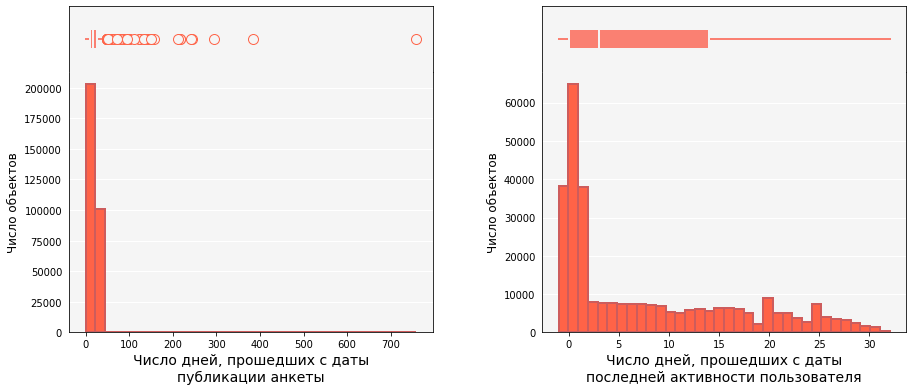

In [30]:
plot_distribution(
    [data['days_posted'], data['days_offline']], kind='hist', bins=[34,34],
    xlabels=['Число дней, прошедших с даты\nпубликации анкеты', 
             'Число дней, прошедших с даты\nпоследней активности пользователя']
)

Абсолютное большинство анкет создано в тот же период (33 дня), когда происходила выгрузка. Удалим из таблицы старые анкеты, чтобы модель обучалась только на актуальных данных.  

In [31]:
n = len(data)
data = data[data['days_posted'] < 34]
test_data = test_data[test_data['days_posted'] < 34]
print('Удалено объектов: {} или {:.2%}'.format(n - len(data), 1 - len(data) / n))

Удалено объектов: 1345 или 0.44%


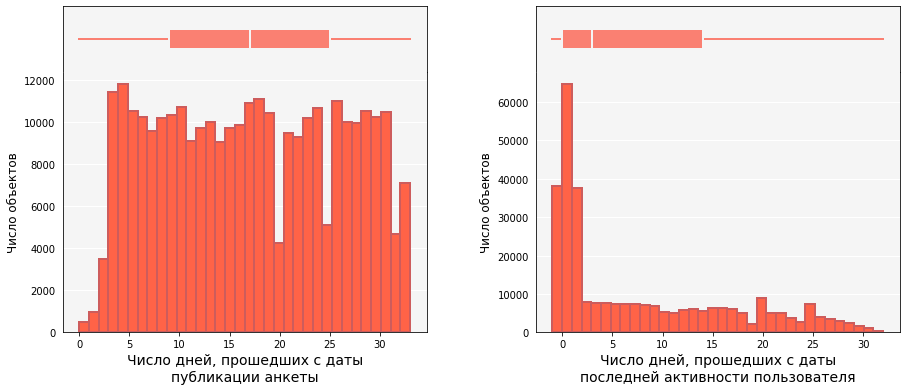

In [32]:
plot_distribution(
    [data['days_posted'], data['days_offline']], kind='hist', bins=[34,34],
    xlabels=['Число дней, прошедших с даты\nпубликации анкеты', 
             'Число дней, прошедших с даты\nпоследней активности пользователя']
)

Видим, что распределение анкет по дате публикации теперь похоже на равномерное.  
Из графика справа видим, что большинство пользователей сервиса были активны в течение последних трёх дней.

## Численные признаки 
[к оглавлению](#start)

В таблице осталось ещё 7 признаков, принимающих численные значения. Выполним предобработку.

In [33]:
num_features = [
    'price', 'registration_year', 'power', 'kilometer', 'registration_month', 'number_of_pictures', 'postal_code'
]

In [34]:
data[num_features].describe().loc[['min', 'mean', '50%', 'max']]

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
min,0.000,1000.000,0.000,5000.000,0.000,0.000,1067.000
mean,4406.758,2004.313,109.702,128244.604,5.714,0.000,50476.500
50%,2700.000,2003.000,105.000,150000.000,6.000,0.000,49356.000
max,20000.000,9999.000,19312.000,150000.000,12.000,0.000,99998.000


Сразу видим множество аномалий:
* нулевые значения цены, мощности и месяца регистрации автомобилей
* аномально маленькие годы регистрации авомобилей, а также автомобили, зарегистрированные после выгрузки анкет (2016 г.)
* аномально высокие значения мощности 
* столбец `number_of_pictures` состоит из одних нулей 

$\to$ столбец `number_of_pictures` удалим из таблицы  
$\to$ создадим копию обучающей выборки `data_` и заменим на *nan* аномалии во всех столбцах, кроме таргета, чтобы посмотреть на распределения признаков 

In [35]:
data = data.drop(columns=['number_of_pictures'])
test_data = test_data.drop(columns=['number_of_pictures'])
num_features.remove('number_of_pictures')

In [36]:
strategies = {
    'registration_year': [None, [1950, 2016]],
    'registration_month': [None, [1, 12]],
    'power': [None, [1, 500]]
}

In [37]:
data_ = data.copy()
ra = RemoveAnomalies(strategies)
data_ = ra.fit_transform(data_)

In [38]:
data_[num_features].describe().loc[['min', 'mean', '50%', 'max']]

,price,registration_year,power,kilometer,registration_month,postal_code
min,0.000,1950.000,1.000,5000.000,1.000,1067.000
mean,4406.758,2002.513,119.928,128244.604,6.389,50476.500
50%,2700.000,2003.000,110.000,150000.000,6.000,49356.000
max,20000.000,2016.000,500.000,150000.000,12.000,99998.000


Теперь значения кажутся более адекватными. Изучим распределения.

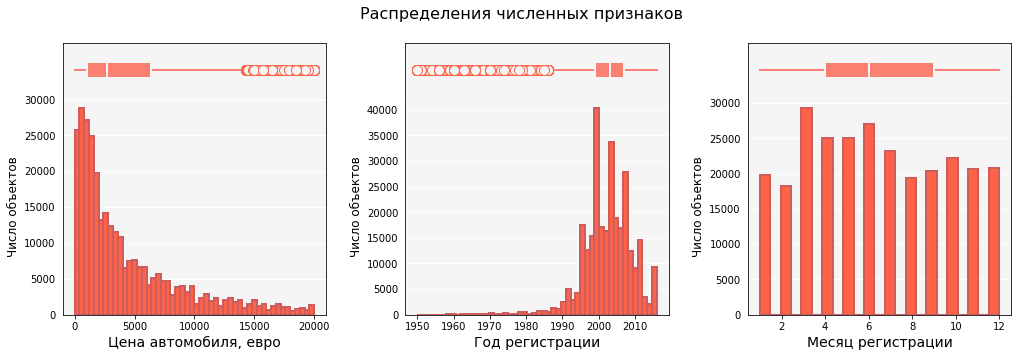

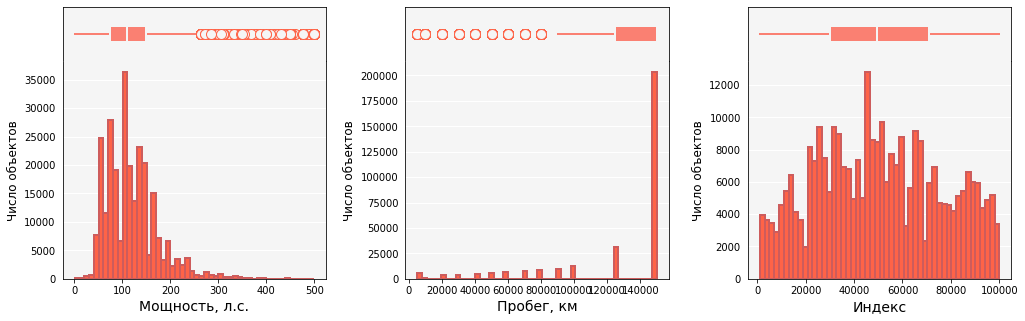

In [39]:
plot_distribution(
    [data_['price'], data_['registration_year'], data_['registration_month']], 
    xlabels=['Цена автомобиля, евро', 'Год регистрации', 'Месяц регистрации'], 
    title='Распределения численных признаков', kind='hist', bins=[50, 50, 23], figsize=(17,5)
)
plot_distribution(
    [data_['power'], data_['kilometer'], data_['postal_code']], 
    xlabels=['Мощность, л.с.', 'Пробег, км', 'Индекс'], kind='hist', bins=[50,50,50], figsize=(17,5)
)

Каких-либо аномалий на гистограммах не видно. 
* У распределений мощности и года регистрации остались длинные хвосты. Пока не будем их обрабатывать — далее сравним качество моделей, обученных на очищенных/неочищенных данных.
* Пробег автомобилей не непрерывен, он принимает 13 дискретных значений
* У многих автомобилей довольно низкая цена. Поскольку нас интересует рыночная стоимость автомобиля, все объекты с нулевым таргетом удалим как из обучающей, так и из тестовой выборок.

In [40]:
n = len(data)
ra = RemoveAnomalies(
    strategies={'price': ['remove', [1, 2e4]]}
)
data = ra.fit_transform(data)
data_ = ra.transform(data_)
test_data = ra.transform(test_data)
print('Удалили объектов:\n\t{} или {:.2%} из обучающей выборки\n\t{} или {:.2%} из тестовой выборки\n'.format(
    n - len(data), 1 - len(data) / n, 50000 - len(test_data), 1 - len(test_data) / 5e4
))

Удалили объектов:
	9203 или 3.04% из обучающей выборки
	1776 или 3.55% из тестовой выборки



Дешёвые автомобили рассмотрим подробнее.

In [41]:
data_[data_['price'] < 10]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,postal_code,days_posted,days_offline
88415,1.000,NaN,2016.000,manual,125.000,vectra,100000,9.000,NaN,opel,yes,59964,2,-1
265322,1.000,sedan,2000.000,auto,310.000,a8,5000,nan,petrol,audi,NaN,41366,12,1
313313,1.000,small,1998.000,manual,125.000,a3,150000,2.000,petrol,audi,no,14480,8,1
287356,1.000,small,1999.000,manual,75.000,lupo,150000,nan,petrol,volkswagen,no,21709,27,-1
179492,1.000,sedan,1999.000,manual,150.000,galant,150000,nan,NaN,mitsubishi,yes,21129,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21172,1.000,wagon,1993.000,manual,140.000,passat,150000,12.000,petrol,volkswagen,NaN,83088,3,0
266471,1.000,bus,1999.000,manual,nan,other,150000,4.000,petrol,renault,no,47652,15,-1
265959,1.000,NaN,1995.000,NaN,nan,polo,150000,nan,NaN,volkswagen,NaN,27305,2,-1
1542,1.000,NaN,2000.000,NaN,nan,astra,150000,nan,NaN,opel,NaN,24601,13,10


Дешёвые автомобили в основном старые (регистрация до 2000 года), с большим пробегом, что вполне логично. Оставим их в выборке.

Масштабы значений численных признаков сильно отличаются, поэтому перед обучением, например, линейной регрессии, их необходимо будет масштабировать. Далее мы сравним нормализацию и стандартизацию и выберем модель с лучшим качеством.

Кроме того, два признака из рассмотренных выше являются категориальными (месяц регистрации и индекс), их необходимо закодировать. Далее будем сравнивать кодировки *OHE* и *OE*.  
С другой стороны, месяц регистрации автомобиля является цикличным признаком, поэтому можно выполнить его синусное/косинусное преобразование: добавить в выборку количественные признаки $sin\left( \frac{2\pi\cdot month}{12}\right)$ и $cos\left( \frac{2\pi\cdot month}{12}\right)$.

In [42]:
data['registration_month_sin'] = np.sin(2 * np.pi * data['registration_month'].replace(0, np.nan) / 12)
data['registration_month_cos'] = np.cos(2 * np.pi * data['registration_month'].replace(0, np.nan) / 12)
test_data['registration_month_sin'] = np.sin(2 * np.pi * test_data['registration_month'].replace(0, np.nan) / 12)
test_data['registration_month_cos'] = np.cos(2 * np.pi * test_data['registration_month'].replace(0, np.nan) / 12)

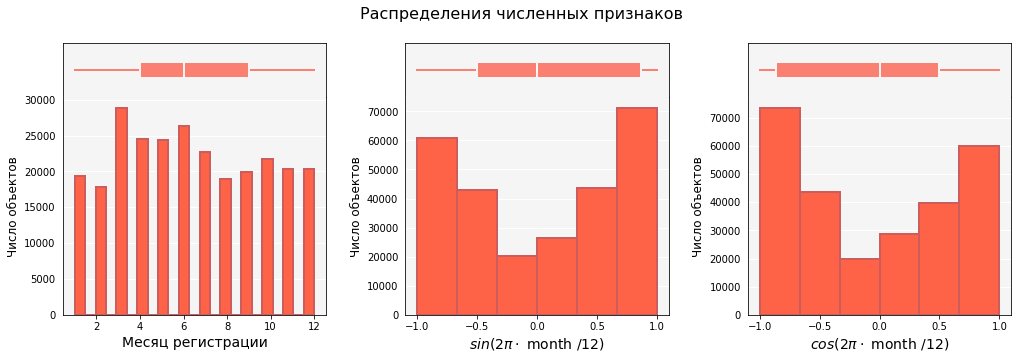

In [43]:
plot_distribution(
    [data['registration_month'].replace(0,np.nan),data['registration_month_sin'],data['registration_month_cos']], 
    xlabels=['Месяц регистрации', '$sin(2\pi\cdot$ month $/ 12)$', '$cos(2\pi\cdot$ month $/ 12)$'], 
    title='Распределения численных признаков', kind='hist', bins=[23, 6, 6], figsize=(17,5)
)

## Категориальные признаки 
[к оглавлению](#start)

Осталось 6 признаков, принимающих строковые значения. Как мы помним, предварительный анализ показал, что в этих столбцах изначально присутствует много пропусков.

In [44]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [45]:
data_[cat_features].describe()

,vehicle_type,gearbox,model,fuel_type,brand,not_repaired
count,264960,278857,278866,268543,293817,237399
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,76442,223451,24208,180200,63828,208358


Сначала рассмотрим два бинарных признака: тип коробки передач и ремонт автомобиля.

In [46]:
data_['gearbox'].replace(np.nan, 'unknown').value_counts(normalize=True).to_frame()

,gearbox
manual,0.761
auto,0.189
unknown,0.051


In [47]:
data_['not_repaired'].replace(np.nan, 'unknown').value_counts(normalize=True).to_frame()

,not_repaired
no,0.709
unknown,0.192
yes,0.099


У большинства автомобилей механическая коробка передач, большинство были в ремонте. В столбце `not_repaired` почти пятая часть значений пропущена. Пропуски можно либо заменить на моду, либо создать отдельную категорию `unknown` — далее сравним эти способы.

Изучим распределения `vehicle_type` и `fuel_type`.

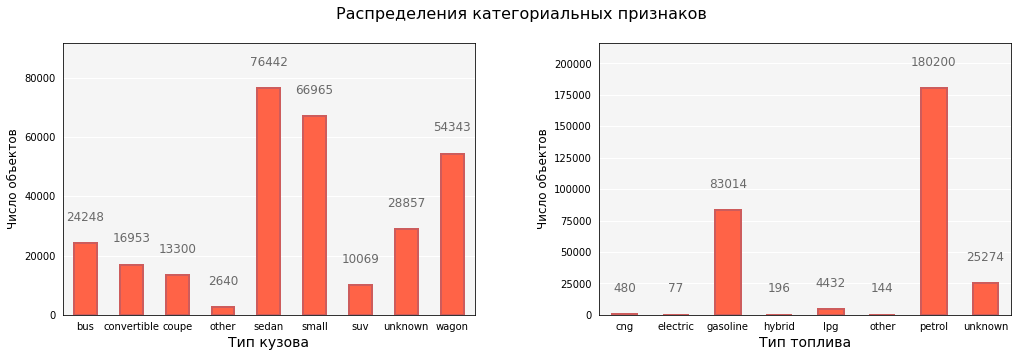

In [48]:
plot_distribution(
    [data_['vehicle_type'].replace(np.nan, 'unknown'), data_['fuel_type'].replace(np.nan, 'unknown')], 
    ['Тип кузова', 'Тип топлива'], 
    title='Распределения категориальных признаков', kind='bar', figsize=(17,5)
)

На графике справа видим большое количество редких значений. Редкие категории можно как оставить без обработки, так и объединить в одну категорию `other` или заменить на моду. Далее сравним эти способы предобработки и выберем лучшую модель.

Осталось два признака с большим числом значений: бренд и модель автомобиля. Приведём все значения к нижнему регистру.

In [49]:
data['brand'] = data['brand'].str.lower()
data['model'] = data['model'].str.lower()

Посмотрим, есть ли редкие категории.

In [50]:
data['brand'].value_counts().tail().to_frame()

,brand
jaguar,427
trabant,426
rover,394
lancia,392
lada,184


In [51]:
data['model'].value_counts().tail(10).to_frame()

,model
samara,11
gl,9
elefantino,8
kalina,7
serie_2,7
i3,6
serie_3,3
rangerover,3
range_rover_evoque,1
serie_1,1


Подвыборки автомобилей различных брендов можно считать репрезентативными, а вот редких моделей довольно много. Далее будут рассмотрены разные способы обработки редких категорий и выбрана лучшая модель.

## Добавление новых признаков 
[к оглавлению](#start)

Добавим признак `age_month` — возраст автомобиля в месяцах на момент выгрузки анкет (04.2016). Автомобили с пропуском в столбце `registration_month` будем считать зарегистрированными в начале года.

In [52]:
data['age_month'] = \
            (2016 - data['registration_year']) * 12 + (4 - data['registration_month'].fillna(1))
test_data['age_month'] = \
            (2016 - test_data['registration_year']) * 12 + (4 - test_data['registration_month'].fillna(1))

Также добавим `depreciation` — [износ автомобиля](https://prava.expert/avtoyurist/strahovanie/kak-rasschityvaetsya-iznos-avtomobilya-po-osago.html#i-4), рассчитанный по формуле:

$$ D = \left(1 - e^{-(\Delta T\cdot T + \Delta L\cdot L)} \right) \cdot 100\%,$$
где
* $Т$ — срок эксплуатации в годах
* $\Delta T$ — коэффициент эксплуатации 
* $L$ — пробег в тыс. км
* $\Delta L$ — коэффициент пробега

Коэффициенты $\Delta T$ и $\Delta L$ зависят от вида транспорта. Возьмём $\Delta T = 0.05$, $\Delta L=0.0024$ для легковых автомобилей и $\Delta T = 0.11$, $\Delta L=0.0008$ для автобусов. Влияние марки автомобиля на коэффициент учитывать не будем.

In [53]:
coefs = pd.DataFrame(index=data.index)
coefs['delta_T'] = data['vehicle_type'].replace(
    ['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 'other'], 
    [0.05, 0.05, 0.05, 0.05, 0.05, 0.11, 0.05, np.nan]
)
coefs['delta_L'] = data['vehicle_type'].replace(
    ['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 'other'], 
    [0.0024, 0.0024, 0.0024, 0.0024, 0.0024, 0.0008, 0.0024, np.nan]
)

In [54]:
test_coefs = pd.DataFrame(index=test_data.index)
test_coefs['delta_T'] = test_data['vehicle_type'].replace(
    ['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 'other'], 
    [0.05, 0.05, 0.05, 0.05, 0.05, 0.11, 0.05, np.nan]
)
test_coefs['delta_L'] = test_data['vehicle_type'].replace(
    ['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 'other'], 
    [0.0024, 0.0024, 0.0024, 0.0024, 0.0024, 0.0008, 0.0024, np.nan]
)

In [55]:
data['depreciation'] = \
    100 * (1 - np.exp(-data['age_month'] / 12 * coefs['delta_T'] - data['kilometer'] / 1000 * coefs['delta_L']))
test_data['depreciation'] = \
    100 * (1 - np.exp(-test_data['age_month'] / 12 * test_coefs['delta_T'] - \
                      test_data['kilometer'] / 1000 * test_coefs['delta_L']))

Изучим распределения новых признаков.

In [56]:
data[['age_month', 'depreciation']].describe().loc[['min', 'mean', '50%', 'max']]

,age_month,depreciation
min,-95796.000,-6.201
mean,140.210,61.444
50%,152.000,64.180
max,12196.000,99.999


Видим, что в обоих столбцах есть аномалии, возникшие из-за того, что данные о дате регистрации не были предобработаны. Удалим аномалии и построим гистограммы.

In [57]:
strategies = {'registration_year': ['remove', [1950, 2015]]}

In [58]:
ra = RemoveAnomalies(strategies)
data_ = ra.fit_transform(data)

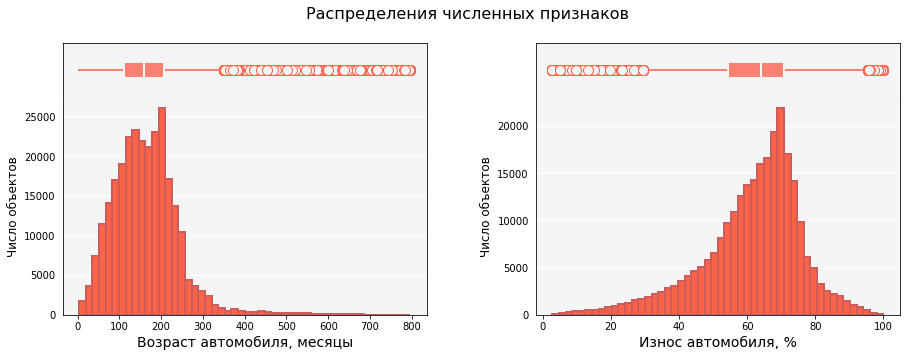

In [59]:
plot_distribution(
    [data_['age_month'], data_['depreciation']], 
    xlabels=['Возраст автомобиля, месяцы', 'Износ автомобиля, %'], title='Распределения численных признаков', 
    kind='hist', bins=[50, 50], figsize=(15,5)
)

In [60]:
data['registration_month'] = data['registration_month'].astype(str)
test_data['registration_month'] = test_data['registration_month'].astype(str)

Распределения выглядят адекватно :)  
Средний возраст автомобилей в выборке ~10 лет, износ ~70%.

### Вывод  <a class="tocSkip">

Предобработка завершена. Изучены распределения всех имеющихся признаков, добавлены новые признаки и удалены неинформативные.

**1. Аномалии**

Аномалии есть как у количественных, так и у категориальных признаков. Границы нормальных значений для каждого признака содержатся в словарях:

In [61]:
num_anomalies = {
    'registration_year': [1950, 2015],
    'age_month': [0, 800],
    'power': [1, 500],
    'depreciation': [0, 100] 
}

In [62]:
cat_anomalies = {'registration_month': ['1', '12']}

Аномалии можно как оставить без изменений, так и предобработать. Возможные способы обработки:
* для численных признаков замена средним/медианой  
* для категориальных замена модой/выделение отдельной категории `unknown`

**2. Выбросы**

У многих количественных признаков тяжёлые хвосты. Границы выбросов:

In [63]:
num_outliers = {
    'registration_year': [1980, 2015],
    'age_month': [0, 400],
    'power': [50, 350], 
}

У некоторых категориальных признаков встречаются многочисленные редкие категории, которые тоже можно считать выбросами. Максимальные объёмы редких категорий для этих признаков содержатся в словаре:

In [64]:
cat_outliers = {
    'fuel_type': 5000,
    'model': 50
}

Выбросы можно как оставить без изменеий, так и заменить характерным значением или выделить отдельную категорию `other`.
    
**3. Пропуски**

Пропуски можно заменить характерным значением, либо объединить в отдельную категорию `unknown`. Признаки с пропусками:

In [65]:
na_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'not_repaired']

___

In [66]:
num_columns = ['registration_year', 'power', 'kilometer', 'days_posted', 'days_offline', 
               'registration_month_sin', 'registration_month_cos', 'age_month', 'depreciation']
cat_columns = ['vehicle_type', 'gearbox', 'model', 'registration_month', 'fuel_type', 
               'brand', 'not_repaired', 'postal_code']

Составим пайплайн предобработки. Он будет содержать обработку аномалий, пропусков и выбросов с последующим кодированием категориальных признаков и масштабированием.

In [67]:
col_transformer = ColumnTransformer(remainder='passthrough', transformers=[
    ('encoder', OneHotEncoder(drop='first', sparse=False), cat_columns),
    ('num_poly', PolynomialFeatures(degree=2, include_bias=False), num_columns)
])
preprocessor = Pipeline(steps=[
    ('num_anomalies', None),
    ('cat_anomalies', None),
    ('num_outliers', None),
    ('cat_outliers', None),
    ('col_transformer', None),
    ('scaler', None)
])

# Анализ данных 
[к оглавлению](#start)

Посмотрим, есть ли взаимосвязь между имеющимися признаками и таргетом. Для этого частично выполним предобработку: удалим все аномалии. Выбросы и пропуски трогать не будем.

In [68]:
strategy = {col : [np.nan, boundaries] for col, boundaries in num_anomalies.items()}
strategy

{'age_month': [nan, [0, 800]],
 'depreciation': [nan, [0, 100]],
 'power': [nan, [1, 500]],
 'registration_year': [nan, [1950, 2015]]}

In [69]:
preprocessor.set_params(
    num_anomalies = RemoveAnomalies(strategy),
    cat_anomalies = RemoveCategories({'registration_month': [np.nan, ['0']]})
)
data_prep = preprocessor.fit_transform(data)

In [70]:
data_prep.describe().loc[['count', 'min', 'max']]

,price,registration_year,power,kilometer,postal_code,days_posted,days_offline,registration_month_sin,registration_month_cos,age_month,depreciation
count,293817.000,274262.000,262310.000,293817.000,293817.000,293817.000,293817.000,265667.000,265667.000,278089.000,262314.000
min,1.000,1950.000,1.000,5000.000,1067.000,0.000,-1.000,-1.000,-1.000,0.000,0.780
max,20000.000,2015.000,500.000,150000.000,99998.000,33.000,32.000,1.000,1.000,796.000,99.999


In [71]:
data_prep.select_dtypes(exclude=[np.number]).describe().loc[['count', 'unique']]

,vehicle_type,gearbox,model,registration_month,fuel_type,brand,not_repaired
count,264960,278857,278866,265667,268543,293817,237399
unique,8,2,250,12,7,40,2


Видим, что предобработка была выполнена правильно: артефактов нет :)

Посмотрим, коррелируют ли признаки и как они связаны с целевой переменной.

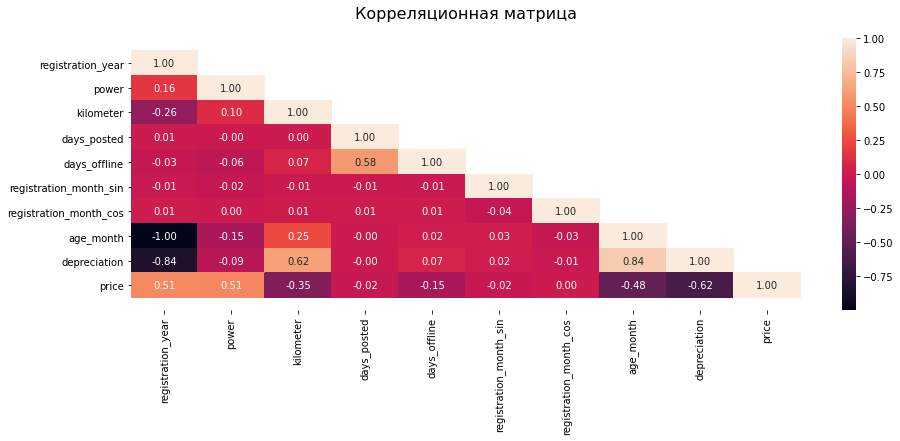

In [72]:
plot_corr_matrix(data_prep[num_columns + ['price']].corr(), mask=True, figsize=(15,5))

* В выборке есть сильно скоррелированные признаки. Например, год регистрации, возраст и износ автомобиля практически линейно зависимы. Эту особенность необходимо будет учесть при обучении линеной модели.
* Почти все признаки связаны с целевым. Радует, что добавленные нами `depreciation` и `age month` сильно коррелируют с таргетом :)

Возможно, взаимосвязь между признаками нелинейная. Проверим это, построив *scatter-plot*. Чтобы ускорить отрисовку графиков, будем рассматривать случайную подвыборку из 10 тыс. объектов.

In [73]:
sample = data_prep.sample(10000, random_state=42)

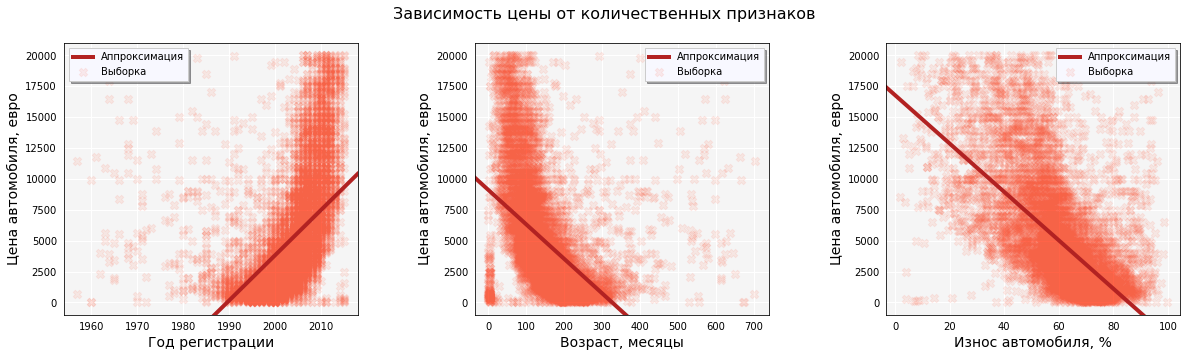

In [74]:
plot_scatter(
    [sample[['registration_year', 'price']], sample[['age_month', 'price']], sample[['depreciation', 'price']]],
    xlabels=['Год регистрации', 'Возраст, месяцы', 'Износ автомобиля, %'], ylabels=['Цена автомобиля, евро'] * 3,
    title='Зависимость цены от количественных признаков', alphas=[0.1, 0.1, 0.1], figsize=(20,5)
)

Связь возраста с таргетом явно нелинейная. Потенцирование немного линеаризовало её: на правом графике точки ближе к линейной аппроксимации.

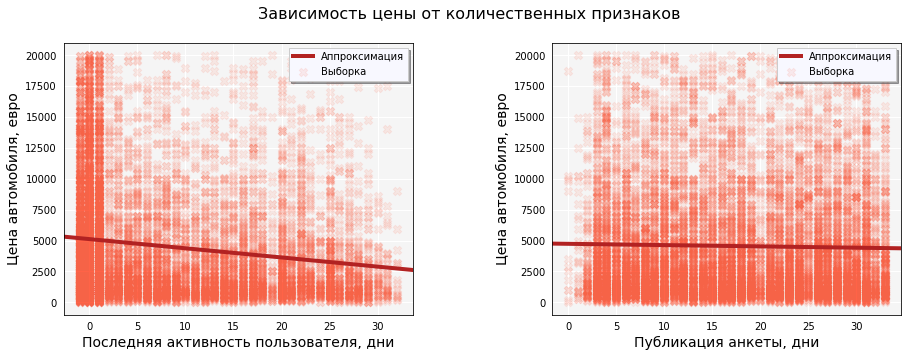

In [75]:
plot_scatter(
    [sample[['days_offline', 'price']], sample[['days_posted', 'price']]], alphas=[0.1,0.1], figsize=(15,5),
    xlabels=['Последняя активность пользователя, дни', 'Публикация анкеты, дни'], 
    ylabels=['Цена автомобиля, евро'] * 2, title='Зависимость цены от количественных признаков' 
)

На правом графике связи с таргетом не наблюдается.

Из левого графика видно, что связь с таргетом есть, но она очень плохо описывается прямой линией.  
Добавим в выборку новый признак `is_active` — активность пользователя 
* 1 — пользователь был активен в последние три дня
* 0 — иначе 

In [76]:
data['is_active'] = data['days_offline'].apply(lambda days: (days < 2) * 1)
test_data['is_active'] = test_data['days_offline'].apply(lambda days: (days < 2) * 1)
data_prep['is_active'] = data_prep['days_offline'].apply(lambda days: (days < 2) * 1)

In [77]:
cat_columns.append('is_active')

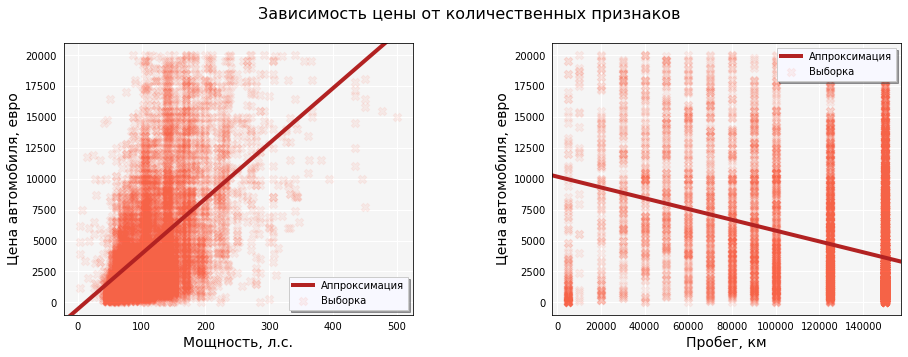

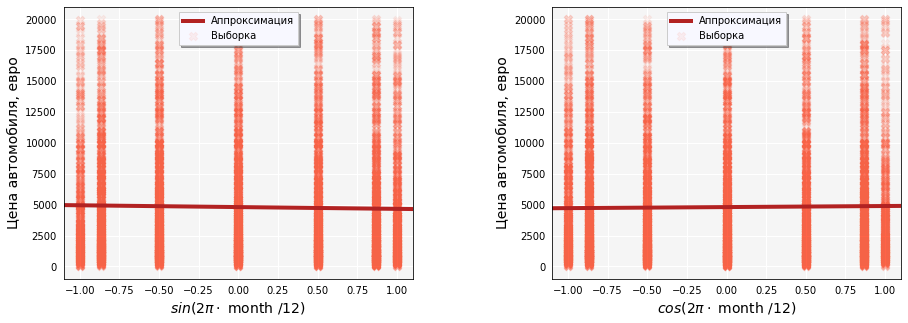

In [78]:
plot_scatter(
    [sample[['power', 'price']], sample[['kilometer', 'price']]], alphas=[0.08,0.08], figsize=(15,5),
    xlabels=['Мощность, л.с.', 'Пробег, км'], ylabels=['Цена автомобиля, евро'] * 2, 
    title='Зависимость цены от количественных признаков' 
)
plot_scatter(
    [sample[['registration_month_sin', 'price']], sample[['registration_month_cos', 'price']]], alphas=[0.08,0.08],
    title='',  ylabels=['Цена автомобиля, евро'] * 2, figsize=(15,5), 
    xlabels=['$sin(2\pi\cdot$ month $/ 12)$', '$cos(2\pi\cdot$ month $/ 12)$'] 
)

Связь таргета с мощностью и пробегом, видимо, нелинейная. Связи с месяцем регистрации не наблюдается.

Таким образом, все количественные признаки, кроме `days_posted`, `registration_month_sin` и `registration_month_cos` напрямую связаны с таргетом, причём связь нелинейная. Для деревянных алгоритмов это не должно быть проблемой, а при обучении линейной модели нужно будет добавить признаки второго порядка и выше.

Теперь рассмотрим связь тартега с категориальными признаками. Построим ящики с усами.

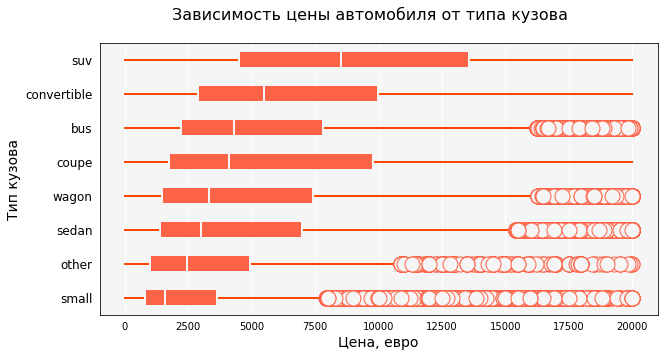

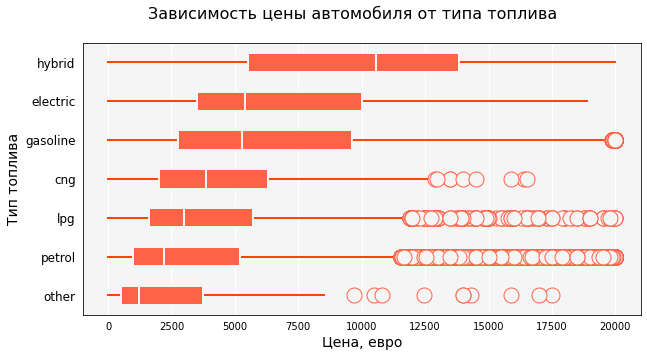

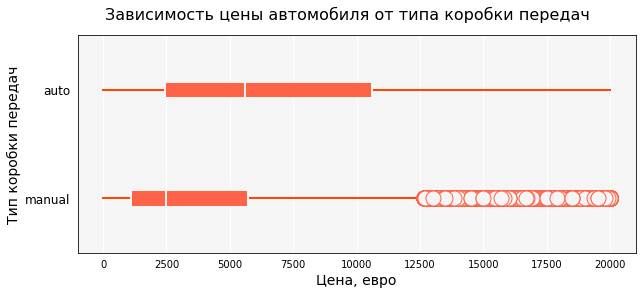

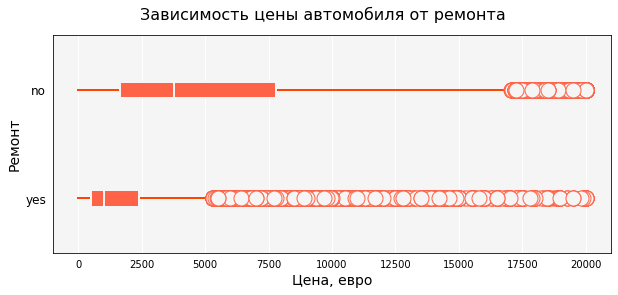

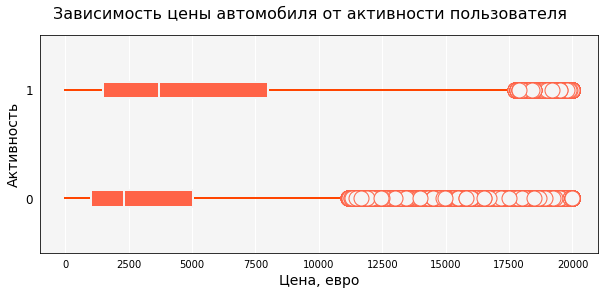

In [79]:
types = data_prep.groupby('vehicle_type')['price'].median().sort_values().index
plot_box(
    [data_prep[data_prep['vehicle_type'] == s]['price'] for s in types],
    labels=['Цена, евро', 'Тип кузова'], ticks=types, 
    title='Зависимость цены автомобиля от типа кузова', figsize=(10,5)
)
types = data_prep.groupby('fuel_type')['price'].median().sort_values().index
plot_box(
    [data_prep[data_prep['fuel_type'] == s]['price'] for s in types],
    labels=['Цена, евро', 'Тип топлива'], ticks=types, 
    title='Зависимость цены автомобиля от типа топлива', figsize=(10,5)
)
plot_box(
    [data_prep[data_prep['gearbox'] == s]['price'] for s in ['manual', 'auto']],
    labels=['Цена, евро', 'Тип коробки передач'], ticks=['manual', 'auto'], 
    title='Зависимость цены автомобиля от типа коробки передач', figsize=(10,4)
)
plot_box(
    [data_prep[data_prep['not_repaired'] == s]['price'] for s in ['yes', 'no']],
    labels=['Цена, евро', 'Ремонт'], ticks=['yes', 'no'], 
    title='Зависимость цены автомобиля от ремонта', figsize=(10,4)
)
plot_box(
    [data_prep[data_prep['is_active'] == s]['price'] for s in [0,1]],
    labels=['Цена, евро', 'Активность'], ticks=[0,1], 
    title='Зависимость цены автомобиля от активности пользователя', figsize=(10,4)
)

$\uparrow$ У всех этих признаков ящики с усами для разных категорий отличаются, значит, признаки информативны :)

Рассмотрим отдельно месяц регистрации автомобиля.

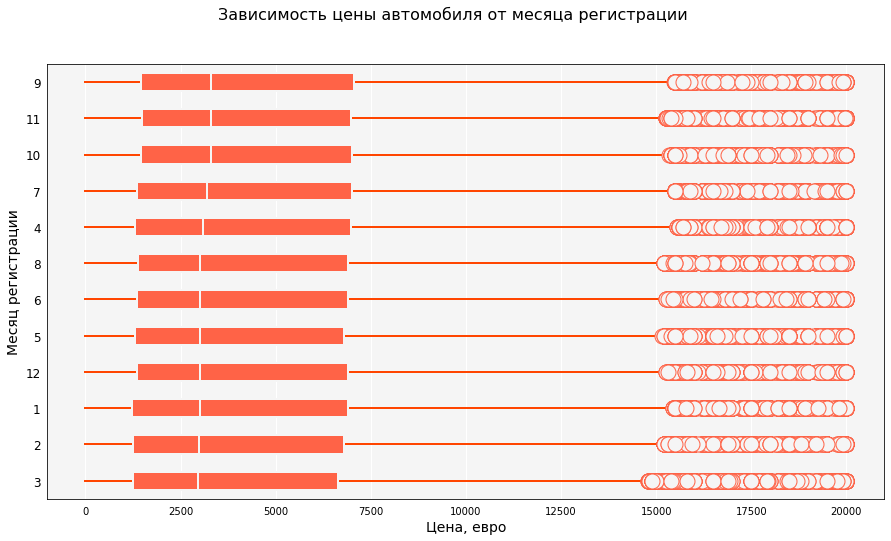

In [80]:
month = data_prep.groupby('registration_month')['price'].median().sort_values().index
plot_box(
    [data_prep[data_prep['registration_month'] == s]['price'] for s in month],
    labels=['Цена, евро', 'Месяц регистрации'], ticks=month, 
    title='Зависимость цены автомобиля от месяца регистрации', figsize=(15,8)
)

Визуально все ящики с усами очень похожи. Возможно, имеет смысл избавиться от этого признака как от неинформативного. Проверим, действительно ли месяц регистрации не влияет на таргет. Сформулируем гипотезы.

* $H_0$: законы распределений цен автомобилей, зарегистрированных в разные месяцы, совпадают.

* $H_1$: законы распределений цен автомобилей, зарегистрированных в разные месяцы, отличаются.

Поскольку распределения скошены влево, для проверки гипотезы будем использовать критерий Манна-Уитни. Выберем уровень значимости $\alpha = 5\%$.

Сначала рассмотрим месяцы 3 и 9 (у них медианные цены отличаются наиболее сильно).

In [81]:
test_hypothesis(
    x=data_prep[data_prep['registration_month'] == '3']['price'], 
    y=data_prep[data_prep['registration_month'] == '9']['price'],
    stat='mannwhitneyu', alpha=0.05
)

p-value: 5.9e-23
Отвергаем нулевую гипотезу


С высокой вероятностью цены автомобилей, зарегистрированных в марте и сентябре, отличаются.  
Теперь рассмотрим месяцы с близкими средними ценами: 3 и 2.

In [82]:
test_hypothesis(
    x=data_prep[data_prep['registration_month'] == '3']['price'], 
    y=data_prep[data_prep['registration_month'] == '2']['price'],
    stat='mannwhitneyu', alpha=0.05
)

p-value: 0.62
Не получилось отвергнуть нулевую гипотезу


Статистические отличия распределений незначительны.  
В целом, можно сказать, что зависимость цены от месяца регистрации есть, но она очень слабая. В то же время, довольно сложно объяснить логически, как месяц регистрации может влиять на цену автомобиля. Кроме того, корреляция таргета с синусом/косиносом месяца регистрации практически нулевая. Удалим все 3 признака из выборки.

In [83]:
data = data.drop(columns=['registration_month', 'registration_month_sin', 'registration_month_cos'])
test_data = test_data.drop(columns=['registration_month', 'registration_month_sin', 'registration_month_cos'])

cat_columns.remove('registration_month')
num_columns.remove('registration_month_sin')
num_columns.remove('registration_month_cos')

Зависимость цены от бренда и модели автомобиля рассматривать не будем, т.к. возможных значений признаков слишком много.

Изучим связь последнего признака — почтового индекса — с таргетом. Значений много, поэтому вместо ящиков с усами построим зависимость средней цены от индекса. Для репрезентативности будем рассматривать категории с более чем 50 объектами.

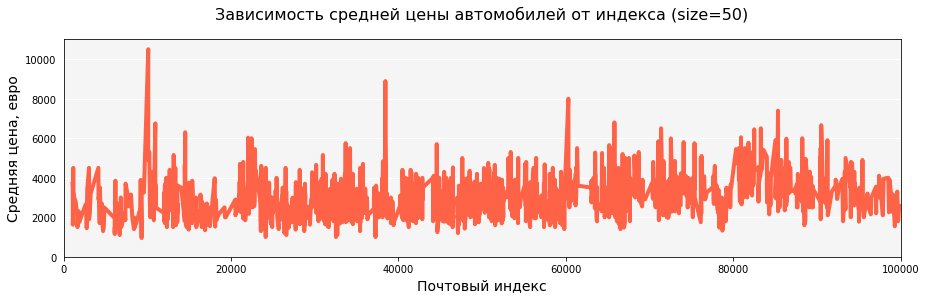

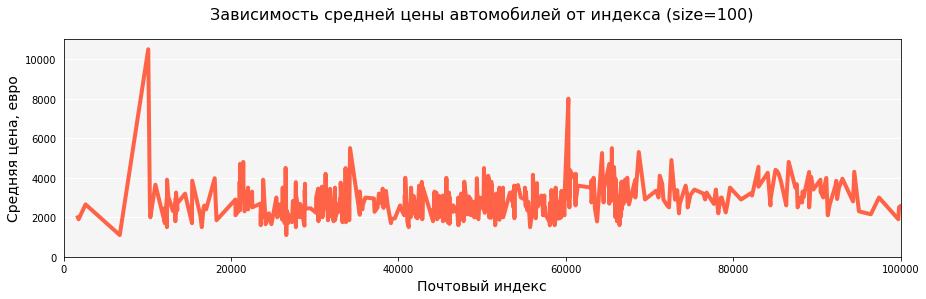

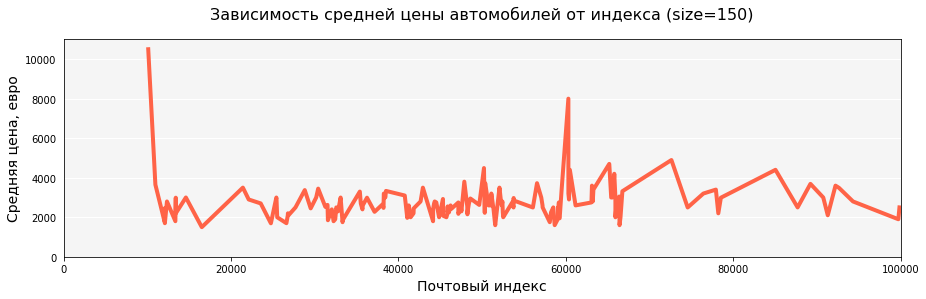

In [84]:
size_groups = data_prep['postal_code'].value_counts()
for size in [50, 100, 150]:
    repr_index = size_groups[size_groups > size].index
    to_plot = data_prep.groupby('postal_code')['price'].median().loc[repr_index].sort_index()
    plot_line(
        x=to_plot.index, y=to_plot, xlabel='Почтовый индекс', ylabel='Средняя цена, евро', 
        figsize=(15,4), xlim=(0, 1e5), ylim=(0, 1.1e4), 
        title='Зависимость средней цены автомобилей от индекса (size={})'.format(size)
    )

Зависимость устроена довольно сложно. Видно, что в зависимости от индекса средняя цена меняется в широких пределах от 2 до 6 тыс. евро. Однако при увеличении минимального объёма подвыборок (`size`) до 100-150 объектов амплитуда 'шума' уменьшается, а медианная цена автомобилей для каждого индекса приближается к медиане всей выборки ~3500 евро. Т.е. изменение средних цен может объясняться нерепрезентативностью подвыборок.  
Удалим признак.

In [85]:
data = data.drop(columns=['postal_code'])
test_data = test_data.drop(columns=['postal_code'])

cat_columns.remove('postal_code')

### Вывод <a class="tocSkip">

* В выборке есть линейно зависимые признаки.
* Практически все признаки напрямую связаны с целевым. Сильная положительная корреляция с таргетом наблюдается у возраста, износа и мощности автомобиля. Связь с количественными признаками в основном нелинейная. Многие категориальные признаками тоже связаны с целевым.

# Обучение модели 
[к оглавлению](#start)

Итак, перед нами задача регресии. Для оценки качества моделей будем использовать метрику RMSE, но также будем сравнивать коэффициенты детерминации, максимальные ошибки и время обучения/предсказания разных моделей.

In [86]:
x_train = data.drop(columns=['price'])
y_train = data['price']
x_test = test_data.drop(columns=['price'])
y_test = test_data['price']

In [87]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', None)
])

### Константная модель <a class="tocSkip">

In [88]:
start_learn = time.time()
mean = y_train.mean()
end_learn = time.time()

In [89]:
start_predict = time.time()
prediction_const =  pd.Series([mean] * len(y_test), index=y_test.index)
end_predict = time.time()

In [90]:
scores = pd.DataFrame({
    'R2': r2_score(y_test, prediction_const), 
    'RMSE': mean_squared_error(y_test, prediction_const)**0.5,
    'max_error': max_error(y_test, prediction_const),
    'learning_time': end_learn - start_learn,
    'prediction_time': end_predict - start_predict
}, index=['Константная модель'])
scores

,R2,RMSE,max_error,learning_time,prediction_time
Константная модель,-0.000,4528.038,15455.213,0.001,0.011


Качество константной модели довольно низкое, средняя ошибка 4.5 тыс. евро.

## Линейная регрессия 
[к оглавлению](#start)

Начнём с обучения простой модели — линейной регрессии на основе SGD. Будем варьировать следующие гиперпараметры:
* тип и коэффициент регуляризации
* шаг градиентного спуска

Также будем сравнивать различные способы предобработки:
* артефакты в численных признаках — заполнение медианой/средним/без предобработки
* артефакты и пропуски в категориальных признаках — заполнение модой/создание категории `unknown`/без предобработки
* выбросы в численных признаках — заполнение медианой/средним/без предобработки
* редкие категории — выделение новой категории `other`/без предобработки

In [91]:
num_anom_median = {col : ['median', boundaries] for col, boundaries in num_anomalies.items()}
num_anom_mean = {col : ['mean', boundaries] for col, boundaries in num_anomalies.items()}

num_out_median = {col : ['median', boundaries] for col, boundaries in num_outliers.items()}
num_out_mean = {col : ['mean', boundaries] for col, boundaries in num_outliers.items()}

cat_nan_freq = {col : ['frequent', 1] for col in na_columns}
cat_nan_unkn = {col : ['unknown', c[1]] for col, c in cat_nan_freq.items()}

cat_out_freq = {col : ['frequent', n] for col, n in cat_outliers.items()}
cat_out_other = {col : ['other', n] for col, n in cat_outliers.items()}

Кодировать признаки будем техникой *OHE*, поскольку для модели линейной регрессии использовать порядковое кодирование некорректно.  
На этапе анализа данных мы обнаружили, что зависимость таргета от количественных признаков нелинейная, поэтому будем варьировать степень `PolynomialFeatures`.  
Кроме того, данные необходимо масштабировать —  будем сравнивать стандартизацию и нормализацию. 

Подбор оптимальных гиперпараметров производился так $\downarrow$

In [92]:
col_transformer.set_params(
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False),
    num_poly = PolynomialFeatures(include_bias=False)
)
pipe.set_params(
    preprocessor__col_transformer = col_transformer,
    model = SGDLinearRegression(max_iter=100)
)

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('num_anomalies',
                                  <__main__.RemoveAnomalies object at 0x7ff4451f7b50>),
                                 ('cat_anomalies',
                                  <__main__.RemoveCategories object at 0x7ff4451f7ad0>),
                                 ('num_outliers', None), ('cat_outliers', None),
                                 ('col_transformer',
                                  ColumnTransformer(n_jobs=None,
                                                    remainder='passthrough',
                                                    sparse_threshold=0.3,
                                                    trans...
                                                                   PolynomialFeatures(degree=2,
                                                                                      include_bias=False,
              

In [ ]:
parameters_grid = {
    'preprocessor__num_anomalies': [RemoveAnomalies(num_anom_median), RemoveAnomalies(num_anom_mean)],
    'preprocessor__num_outliers': [RemoveAnomalies({}), RemoveAnomalies(num_out_median), RemoveAnomalies(num_out_mean)],
    'preprocessor__cat_anomalies': [RemoveCategories(cat_nan_unkn), RemoveCategories(cat_nan_freq)],
    'preprocessor__cat_outliers': [RemoveCategories(cat_out_other), RemoveCategories(cat_out_freq), RemoveCategories({})],
    'preprocessor__col_transformer__num_poly__degree': [1,2,3,4],
    'preprocessor__scaler': [StandardScaler(), MinMaxScaler()],
    'model__penalty': ['l1', 'l2'],
    'model__alpha': [1e-5, 1e-4, 1e-3, 1e-2],
    'model__eta': [1e-4, 1e-3, 1e-2]
}

gs = GridSearchCV(pipe, parameters_grid, scoring='neg_mean_squared_error', cv=3)
gs.fit(x_train, y_train)
print('RMSE (кросс-валидация): {:.3f}'.format((-gs.best_score_)**0.5))

# output    RMSE (кросс-валидация): 1993.329 (1963.535 at 50 iter)

Оптимальной оказалась регрессия с лассо-регуляризацией $\alpha = 10^{-4}$ и шагом GD $\eta = 10^{-3}$. Аномалии в количественных признаках заполняются медианой, выбросы не обрабатыаются. Пропуски в категориальных признаках объединятся в категорию `unknown`, редкие категории — в общую категорию `other`. В выборку добавляются признаки 2 — 4 порядков, признаки стандартизируются.

Оценим на кросс-валидации качество модели с оптимальными гиперпараметрами.

In [93]:
params_lr = {
    'preprocessor__num_anomalies': RemoveAnomalies(num_anom_median),
    'preprocessor__num_outliers': RemoveAnomalies({}),
    'preprocessor__cat_anomalies': RemoveCategories(cat_nan_unkn),
    'preprocessor__cat_outliers': RemoveCategories(cat_out_other),
    'preprocessor__col_transformer__encoder': OneHotEncoder(handle_unknown='ignore', sparse=False),
    'preprocessor__col_transformer__num_poly': PolynomialFeatures(degree=4, include_bias=False),
    'preprocessor__scaler': StandardScaler(),
    'model': SGDLinearRegression(penalty='l1', alpha=1e-4, eta=1e-3, max_iter=100)
}

In [94]:
pipe.set_params(**params_lr)

cv_scores = scores.copy()
cv_scores.loc['Линейная регрессия'] = get_cv_scores(pipe, x_train, y_train)
cv_scores

,R2,RMSE,max_error,learning_time,prediction_time
Константная модель,-0.000,4528.038,15455.213,0.001,0.011
Линейная регрессия,0.812,1954.088,-23403.968,131.065,1.350


И коэффициент детерминации, и RMSE значительно улучшились.

Посмотрим, было ли достаточно 100 эпох для достижения сходимости.

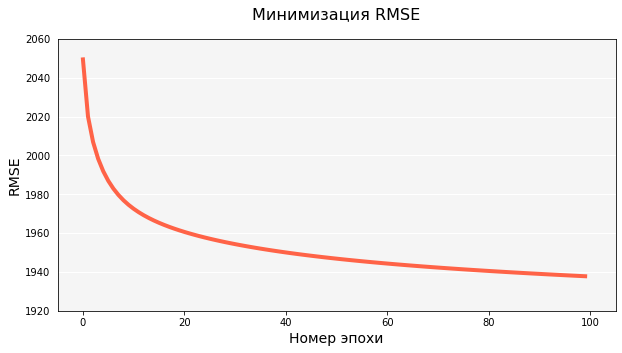

In [95]:
pipe.fit(x_train, y_train)
loss = [x**0.5 for x in pipe.named_steps['model'].loss_opt]
plot_line(
    x=np.arange(0, len(loss)), y=loss, xlabel='Номер эпохи', ylabel='RMSE', 
    title='Минимизация RMSE', xlim=(-5, len(loss) + 5), ylim=(1920, 2060)
)

За 100 эпох RMSE вышла на константу — можно считать, что задача сошлась. На последних итерациях RMSE $\approx 1940$, что несильно отличается от оценки на кросс-валидации (RMSE$=1954$) $\to$ модель не переобучена.

Посмотрим на веса признаков.

In [96]:
ohe_cols = list(pipe['preprocessor']['col_transformer'].transformers_[0][1].get_feature_names(cat_columns))
poly_cols = list(pipe['preprocessor']['col_transformer'].transformers_[1][1].get_feature_names(num_columns))

In [97]:
feature_weights = pd.DataFrame(pipe['model'].w, index=ohe_cols + poly_cols, columns=['weight'])
feature_weights.loc['intercept'] = pipe['model'].w0
feature_weights.loc[feature_weights.abs().sort_values(by='weight', ascending=False).index].head(20)

,weight
intercept,4542.055
power kilometer^2 depreciation,-1457.450
power kilometer age_month^2,1415.000
power age_month depreciation^2,1387.235
power^3,-1311.817
registration_year power^3,-1305.070
power^2 kilometer age_month,-1139.012
power kilometer age_month depreciation,1122.825
registration_year^3 power,1064.257
power^2 age_month^2,-1054.095


Видим, что наиболее значимые признаки — это мощность, возраст и пробег автомобиля, а также их комбинации. 

In [98]:
feature_weights.loc[feature_weights.abs().sort_values(by='weight', ascending=False).index].tail(10)

,weight
model_arosa,1.765
model_lancer,1.597
model_carisma,-1.388
model_bora,-1.260
kilometer days_posted days_offline,-1.039
model_forfour,0.919
model_accord,-0.280
registration_year kilometer^2 age_month,-0.190
model_phaeton,0.145
registration_year^2 power^2,-0.066


Наименьшие веса у закодированных категориальных признаков и у признаков 3-4 степени, что вполне логично.  

В целом, модель кажется адекватной :)

## Случайный лес
[к оглавлению](#start)

Рассмотрим более сложную модель — случайный лес. Будем варьировать гиперпараметры:
* максимальная глубина базового дерева
* минимальное число объектов в листьях
* максимальное число признаков, учитывающихся при поиске лучшего разбиения

Добавлять признаки второго порядка не будем, масштабировать признаки — тоже, т.к. для деревянных алгоритмов это не требуется. Будем сравнивать техники кодирования категориальных признаков *OHE* и *OE*.

In [ ]:
pipe.set_params(
    preprocessor__col_transformer__num_poly = 'passthrough',
    preprocessor__scaler = None,
    model = RandomForestRegressor(random_state=42, n_estimators=100)
)
parameters_grid = {
    'preprocessor__num_anomalies': [RemoveAnomalies(num_anom_mean), RemoveAnomalies(num_anom_median)],
    'preprocessor__cat_anomalies': [RemoveCategories(cat_nan_unkn), RemoveCategories(cat_nan_freq)],
    'preprocessor__num_outliers': [RemoveAnomalies({}), RemoveAnomalies(num_out_mean)],
    'preprocessor__cat_outliers': [RemoveCategories({}), RemoveCategories(cat_out_other)],
    'preprocessor__col_transformer__encoder': [OrdinalEncoder(), OneHotEncoder(handle_unknown='ignore', sparse=False)],
    'model__max_depth' : [5, 10, 20, 30], 
    'model__min_samples_leaf': [1, 10, 50],
    'model__max_features' : [0.3, 0.5, 0.8],
}
gs = GridSearchCV(pipe, parameters_grid, scoring='neg_mean_squared_error', cv=3)
gs.fit(x_train, y_train)
print('RMSE (кросс-валидация): {:.3f}'.format((-gs.best_score_)**0.5)) 

# output RMSE (кросс-валидация): 1716.600

Подобрали оптимальные гиперпараметры: аномалии в количественных признаках заполняются средним, пропуски в категориальных признаках объединятся в категорию `unknown`, выбросы никак не обрабатыватся. Признаки кодируются техникой *OE*.

In [99]:
params_rf = {
    'preprocessor__num_anomalies': RemoveAnomalies(num_anom_mean),
    'preprocessor__num_outliers': RemoveAnomalies({}),
    'preprocessor__cat_anomalies': RemoveCategories(cat_nan_unkn),
    'preprocessor__cat_outliers': RemoveCategories({}),
    'preprocessor__col_transformer__encoder': OrdinalEncoder(),
    'preprocessor__col_transformer__num_poly': 'passthrough',
    'preprocessor__scaler': None,
    'model': RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1,
                                   max_features=0.5, n_estimators=100)
}

In [100]:
pipe.set_params(**params_rf)

cv_scores.loc['Случайный лес'] = get_cv_scores(pipe, x_train, y_train)
cv_scores

,R2,RMSE,max_error,learning_time,prediction_time
Константная модель,-0.000,4528.038,15455.213,0.001,0.011
Линейная регрессия,0.812,1954.088,-23403.968,131.065,1.350
Случайный лес,0.867,1643.945,-18306.163,69.983,3.884


Качество модели получилось выше :)  
Вероятно, линейная регрессия недообучалась. Посмотрим на важность признаков.

In [101]:
pipe.fit(x_train, y_train)
feature_weights = pd.DataFrame(
    pipe['model'].feature_importances_, index=cat_columns + num_columns, columns=['importance']
)
feature_weights.sort_values(by='importance', ascending=False)

,importance
registration_year,0.303
power,0.215
age_month,0.169
depreciation,0.103
brand,0.041
vehicle_type,0.031
model,0.029
kilometer,0.026
gearbox,0.018
days_posted,0.017


Действительно, в отличие от предыдущей модели, в случайном лесе категориальные признаки (вроде бренда и марки автомобиля) оказались значимыми.  
При обучении линейной модели не учитывались признаки-комбинации категориальных и количественных — из-за этого её качество получилось намного хуже по сравнению с качеством деревянной модели, которая способна находить сложные взаимосвязи признаков с таргетом. Имеет смысл рассмотреть другие деревянные алгоритмы. 

## CatBoost 
[к оглавлению](#start)

Обучим CatBoost — одну из реализаций градиентного бустинга над решающими деревьями. Будем варьировать:
* глубину деревьев
* число базовых моделей
* скорость обучения

Снова сравним различные способы предобработки. Масштабировать признаки не будем. Обработку кат. признаков оставим кэтбусту.

In [ ]:
pipe.set_params(model=CatBoostRegressor(random_state=42, cat_features=cat_columns, iterations=200, verbose=False))

parameters_grid = {
    'preprocessor__num_anomalies': [RemoveAnomalies(num_anom_median), RemoveAnomalies(num_anom_mean), RemoveAnomalies({})],
    'preprocessor__cat_anomalies': [RemoveCategories(cat_nan_unkn), RemoveCategories(cat_nan_freq)],
    'preprocessor__num_outliers': [RemoveAnomalies({}), RemoveAnomalies(num_out_median)],
    'preprocessor__cat_outliers': [RemoveCategories({}), RemoveCategories(cat_out_other)],
    'model__depth' : [5,10,15],
    'model__learning_rate' : [0.1, 0.3, 0.5]
}

gs = GridSearchCV(pipe, parameters_grid, scoring='neg_mean_squared_error', cv=3)
gs.fit(x_train, y_train)
print('RMSE (кросс-валидация): {:.3f}'.format((-gs.best_score_)**0.5)) 

# output    RMSE (кросс-валидация): 1605.701

Оптимальным оказался бустинг над неглубокими деревьями (`depth=12`) с шагом `learning_rate=0.3`.    
Предобработка включает заполнение пропусков в категориальных признаках значением `unknown` и аномалий в численных признаках средним значением. Градиентный бустинг устойчив к выбросам, поэтому, как и ожидалось, предобработка выбросов только ухудшала качество.

In [102]:
params_cat = {
    'preprocessor__num_anomalies': RemoveAnomalies(num_anom_mean),
    'preprocessor__num_outliers': RemoveAnomalies({}),
    'preprocessor__cat_anomalies': RemoveCategories(cat_nan_unkn),
    'preprocessor__cat_outliers': RemoveCategories(cat_out_other),
    'preprocessor__col_transformer__encoder': 'passthrough',
    'preprocessor__col_transformer__num_poly': 'passthrough',
    'preprocessor__scaler': None,
    'model': CatBoostRegressor(random_state=42, cat_features=np.arange(len(cat_columns)), verbose=False,
                               depth=12, iterations=200, learning_rate=0.3)
}

In [103]:
pipe.set_params(**params_cat)
cv_scores.loc['CatBoost'] = get_cv_scores(pipe, x_train, y_train)
cv_scores

,R2,RMSE,max_error,learning_time,prediction_time
Константная модель,-0.000,4528.038,15455.213,0.001,0.011
Линейная регрессия,0.812,1954.088,-23403.968,131.065,1.350
Случайный лес,0.867,1643.945,-18306.163,69.983,3.884
CatBoost,0.873,1605.701,-19390.194,156.232,0.881


Качество ещё улучшилось, но вместе с ним возросло и время обучения модели. 

In [104]:
pipe.fit(x_train, y_train)
feature_importances_cb = \
    pd.DataFrame(pipe.named_steps['model'].get_feature_importance(), index=x_train.columns, columns=['importance'])
feature_importances_cb.sort_values(by='importance', ascending=False)

,importance
not_repaired,18.202
brand,17.354
model,14.132
vehicle_type,8.702
days_posted,7.522
depreciation,7.439
gearbox,6.990
kilometer,4.184
is_active,4.171
power,3.559


У этой модели все наиболее значимые признаки — категориальные. При этом странно, что возраст и пробег автомобиля имеют небольшой вес, а, например, число дней, прошедших с даты публикации объявления, оказалось важно.

<a id="step5_2"></a>
## XGBoost 
[к оглавлению](#start)

Рассмотрим ещё одну реализацию градиентного бустинга над решающими деревьями — XGBoost.  
Варьируем те же гиперпараметры, что и в предыдущей модели. Также добавим кодирование категориальных признаков: будем сравнивать техники *OE* и *OHE*.

In [ ]:
pipe.set_params( 
    preprocessor__col_transformer__num_poly='passthrough', 
    model=XGBRegressor(random_state=42, n_estimators=200) 
)

parameters_grid = { 
    'preprocessor__num_anomalies': [RemoveAnomalies(num_anom_median), RemoveAnomalies(num_anom_mean), RemoveAnomalies({})],
    'preprocessor__cat_anomalies': [RemoveCategories(cat_nan_unkn), RemoveCategories(cat_nan_freq)],
    'preprocessor__num_outliers': [RemoveAnomalies({}), RemoveAnomalies(num_out_median)],
    'preprocessor__cat_outliers': [RemoveCategories({}), RemoveCategories(cat_out_other)],
    'preprocessor__col_transformer__encoder': [OrdinalEncoder(), OneHotEncoder(handle_unknown='ignore', sparse=False)], 
    'model__max_depth': [5,10,15],
    'model__learning_rate': [0.1, 0.2, 0.3] 
} 
gs = GridSearchCV(pipe, parameters_grid, scoring='neg_mean_squared_error', cv=3)
gs.fit(x_train, y_train)
print('RMSE (кросс-валидация): {:.3f}'.format((-gs.best_score_)**0.5)) 

# output    RMSE (кросс-валидация): 1586.169

Оптимальные гиперпараметры практически не изменились. Теперь предобработка включает только заполнение пропусков и кодирование техникой *OHE*. 

In [105]:
params_xgb = {
    'preprocessor__num_anomalies': RemoveAnomalies({}),
    'preprocessor__num_outliers': RemoveAnomalies({}),
    'preprocessor__cat_anomalies': RemoveCategories(cat_nan_unkn),
    'preprocessor__cat_outliers': RemoveCategories({}),
    'preprocessor__col_transformer__encoder': OneHotEncoder(drop='first', sparse=False),
    'preprocessor__col_transformer__num_poly': 'passthrough',
    'preprocessor__scaler': None,
    'model': XGBRegressor(random_state=42, n_estimators=200, max_depth=10, learning_rate=0.2)
}

In [106]:
pipe.set_params(**params_xgb)
cv_scores.loc['XGBoost'] = get_cv_scores(pipe, x_train, y_train)
cv_scores

[20:04:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:16:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:29:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,R2,RMSE,max_error,learning_time,prediction_time
Константная модель,-0.000,4528.038,15455.213,0.001,0.011
Линейная регрессия,0.812,1954.088,-23403.968,131.065,1.350
Случайный лес,0.867,1643.945,-18306.163,69.983,3.884
CatBoost,0.873,1605.701,-19390.194,156.232,0.881
XGBoost,0.876,1586.169,-19593.648,744.726,2.719


RMSE уменьшилась всего на 20 евро, при этом время обучения возросло в разы :(

In [107]:
pipe.fit(x_train, y_train)
ohe_feature_names = \
    list(pipe.named_steps['preprocessor']['col_transformer'].transformers_[0][1].get_feature_names(cat_columns)) \
        + num_columns

feature_importances_xgb_ = pd.concat([
    pd.DataFrame(pipe['model'].get_booster().get_score(importance_type='total_gain'), index=['importance']),
    pd.DataFrame({'f{}'.format(ohe_feature_names.index(f)) : f for f in ohe_feature_names}, index=['feature'])
]).T.set_index('feature')

feature_importances_xgb_.sort_values(by='importance', ascending=False).head(10)

[20:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,importance
feature,
depreciation,6582698391618.874
power,3894786444197.353
age_month,1925397241994.323
registration_year,419200170227.501
kilometer,349070174149.361
model_transporter,182569413608.438
vehicle_type_convertible,180978491751.418
not_repaired_yes,165161031499.349
fuel_type_gasoline,107039817559.694


Наиболее значимые признаки — износ, мощность и возраст автомобиля. Эта модель кажется более адекватной :)

<a id="step5_3"></a>
## LightGBM 
[к оглавлению](#start)

Последняя реализация градиентного бустинга, которую мы рассмотрим, — LightGBM. Она, как и catboost, умеет работать с категориальными признаками. Посмотрим, улучшит ли это качество.

In [ ]:
pipe.set_params(
    model=LGBMRegressor(random_state=42, verbose=None)
)

parameters_grid = [{
    'preprocessor__num_anomalies': [RemoveAnomalies(num_anom_mean), RemoveAnomalies(num_anom_median)],
    'preprocessor__cat_anomalies': [RemoveCategories(cat_nan_unkn), RemoveCategories(cat_nan_freq)],
    'preprocessor__num_outliers': [RemoveAnomalies({}), RemoveAnomalies(num_out_mean)],
    'preprocessor__cat_outliers': [RemoveCategories({}), RemoveCategories(cat_out_other)],
    'preprocessor__col_transformer__encoder': [oe_encoder, ohe_encoder],
    'model__categorical_feature': [None],
    'model__depth' : [8], 
    'model__iterations' : [200],
    'model__learning_rate' : [0.2] 
}, {
    'preprocessor__num_anomalies': [RemoveAnomalies(num_anom_mean), RemoveAnomalies(num_anom_median)],
    'preprocessor__cat_anomalies': [RemoveCategories(cat_nan_unkn), RemoveCategories(cat_nan_freq)],
    'preprocessor__num_outliers': [RemoveAnomalies({}), RemoveAnomalies(num_out_mean)],
    'preprocessor__cat_outliers': [RemoveCategories({}), RemoveCategories(cat_out_other)],
    'preprocessor__col_transformer__encoder': [oe_encoder],
    'model__categorical_feature': [np.arange(len(cat_columns))],
    'model__depth' : [8],
    'model__iterations' : [200],
    'model__learning_rate' : [0.2] 
}]
gs = GridSearchCV(pipe, parameters_grid, scoring='neg_mean_squared_error', cv=3)
gs.fit(x_train, y_train)
print('RMSE (кросс-валидация): {:.3f}'.format((-gs.best_score_)**0.5)) 

# output RMSE (кросс-валидация): 1625.490

Действительно, оптимальным оказалось передавть LightGBM список кат. признаков, а не кодировать их самостоятельно :) В отличие от предыдущих моделей, здесь количественные признаки никак не предобрабатываются.

In [108]:
params_lgbm = {
    'preprocessor__num_anomalies': RemoveAnomalies({}),
    'preprocessor__num_outliers': RemoveAnomalies({}),
    'preprocessor__cat_anomalies': RemoveCategories(cat_nan_unkn),
    'preprocessor__cat_outliers': RemoveCategories(cat_out_freq),
    'preprocessor__col_transformer__encoder': OrdinalEncoder(),
    'preprocessor__col_transformer__num_poly': 'passthrough',
    'preprocessor__scaler': None,
    'model': LGBMRegressor(random_state=42, verbose=None, categorical_feature=np.arange(len(cat_columns)),
                           max_depth=14, n_estimators=1000, learning_rate=0.2)
}

In [109]:
pipe.set_params(**params_lgbm)
cv_scores.loc['LightGBM'] = get_cv_scores(pipe, x_train, y_train)
cv_scores

,R2,RMSE,max_error,learning_time,prediction_time
Константная модель,-0.000,4528.038,15455.213,0.001,0.011
Линейная регрессия,0.812,1954.088,-23403.968,131.065,1.350
Случайный лес,0.867,1643.945,-18306.163,69.983,3.884
CatBoost,0.873,1605.701,-19390.194,156.232,0.881
XGBoost,0.876,1586.169,-19593.648,744.726,2.719
LightGBM,0.879,1567.715,-20260.713,13.667,6.909


Высокое качество + быстрое обучение. Ура :)

In [110]:
pipe.fit(x_train, y_train)
feature_importances_lgbm = pd.DataFrame(pipe['model'].feature_importances_, columns=['importance'], 
                                        index=cat_columns + num_columns)
feature_importances_lgbm.sort_values(by='importance', ascending=False)

,importance
power,4806
depreciation,4566
age_month,3744
model,3640
days_posted,2940
days_offline,2127
kilometer,1851
registration_year,1645
brand,1205
vehicle_type,889


Список значимых признаков кажется вполне адекватным. Похоже, эта модель является лучшей из всех рассмотренныых :)

# Оценка качества

Итак, лучшее качество на кросс-валидации получилось у градиентного бустинга (`LGBMRegressor`). Проверим теперь качество на тесте.

In [111]:
start_learn = time.time()
pipe.set_params(**params_lgbm)
pipe.fit(x_train, y_train)
end_learn = time.time()

In [112]:
start_predict = time.time()
pred = pd.Series(pipe.predict(x_test), index=x_test.index)
end_predict = time.time()

In [113]:
scores.loc['Градиентный бустинг'] = [
    r2_score(y_test, pred),
    mean_squared_error(y_test, pred)**0.5,
    max_error(y_test, pred),
    end_learn - start_learn,
    end_predict - start_predict
]
scores

,R2,RMSE,max_error,learning_time,prediction_time
Константная модель,-0.000,4528.038,15455.213,0.001,0.011
Градиентный бустинг,0.884,1542.746,18700.544,19.346,3.485


Качество получилось немного лучше, чем на кросс-валидации :)

In [114]:
feature_importances_lgbm = pd.DataFrame(pipe['model'].feature_importances_, columns=['importance'], 
                                        index=cat_columns + num_columns)
feature_importances_lgbm.sort_values(by='importance', ascending=False)

,importance
power,4806
depreciation,4566
age_month,3744
model,3640
days_posted,2940
days_offline,2127
kilometer,1851
registration_year,1645
brand,1205
vehicle_type,889


## Анализ остатков

In [115]:
resid = pd.DataFrame({'true': y_test, 'pred': pred})
resid['delta'] = resid['pred'] - resid['true']

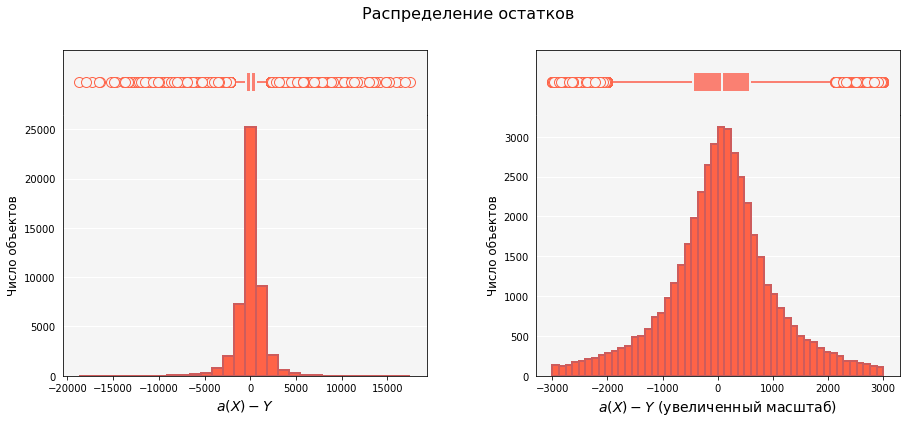

,delta
min,-18700.544
mean,0.293
50%,67.645
max,17471.460


In [116]:
plot_distribution(
    [resid['delta'], resid[resid['delta'].abs() < 3000]['delta']], kind='hist', bins=[30,50], 
    title='Распределение остатков', xlabels=['$a(X) - Y$', '$a(X) - Y$ (увеличенный масштаб)'], 
)
resid['delta'].describe().to_frame().loc[['min', 'mean', '50%', 'max']]

Распределение остатков унимодальное и симметричное. Остатки получились немного смещённые.  
Посмотрим, есть ли зависимость от истинных значений.

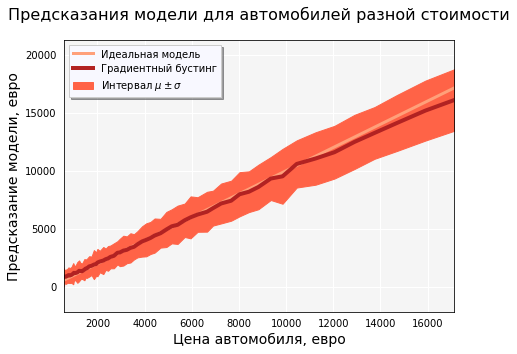

In [117]:
plot_true_pred(y_test, pred, 70, label='Градиентный бустинг')

Из графика видим, что кривые для идеальной модели и градиентного бустинга практически совпадают $\to$ в среднем модель неплохо оценивает стоимость автомобилей во всём ценовом диапазоне. Сильные отличия реальных и предсказанных цен наблюдаются для:
* самых дешёвых автомобилей (<1 тыс. евро) — кривая для `LightGBM` идёт выше, т.е. модель в среднем завышает стоимость
* самых дорогих автомобилей (>10 тыс. евро) — модель занижает стоимость

Это может объясняться 
1. Непрезентативностью подвыборок. В обучающей выборке относительно немного автомобилей стоимостью <1 тыс. или >10 тыс. евро $\to$ модель могла недообучиться.  
*Решение:* собрать больше данных об очень дешёвых/дорогих автомобилях.
2. Неполными данными об автомобилях. Возможно, есть признаки, сильно влияющие на стоимость автомобиля, но отсутствующие в выборке. Например, низкая цена может объясняться тем, что автомобиль не на ходу, но этих данных у нас нет.  
*Решение:* собирать более подробную информацию об автомобилях.
2. При подаче объявления о продаже автомобиля пользователи могли необъективно оценить стоимость автомобиля.  
*Решение:* наша задача — предсказывать рыночную стоимость автомобиля, поэтому логичнее собирать данные не о продаваемых, а об уже проданных автомобилях.

На графике есть ещё одна интересная особенность: на круглых числах отклонения предсказаний от истинных значений таргета более сильные. Это особенно заметно для автомобилей стоимостью 10 тыс. евро — модель занижает их цену, в то время как для автомобилей 9 и 11 тыс. евро предскзания более точные.  
Это может объясняться тем, что пользователи склонны устанавливать круглую цену при продаже автомобиля. Причём, они могут как занижать цену до круглого числа, так и завышать. Например, для автомобилей стоимостью 6 тыс. евро модель в среднем предсказывает 6 тыс. евро, однако разброс предсказанных цен довольно большой по сравнению с соседними точками.

<a id="step6"></a>
# Общий вывод 
[к оглавлению](#start)

Исследование рыночной стоимости автомобилей завершено.

1. Выполнена предобработка данных.
2. Проведён исследовательский анализ данных. Изучены распределения автомобилей по имеющимся признакам. Проанализированы взаимосвязи между признаками и их корреляция со стоимостью.
3. Обучены пять моделей машинного обучения, с хорошей точностью предсказывающие рыночную стоимость автомобиля. Проанализированы сильные и слабые стороны моделей.

### Основные результаты <a class="tocSkip">

1. Качество моделей и время обучения/предсказания представлены в таблице (оценка на кросс-валидации):

In [118]:
cv_scores

,R2,RMSE,max_error,learning_time,prediction_time
Константная модель,-0.000,4528.038,15455.213,0.001,0.011
Линейная регрессия,0.812,1954.088,-23403.968,131.065,1.350
Случайный лес,0.867,1643.945,-18306.163,69.983,3.884
CatBoost,0.873,1605.701,-19390.194,156.232,0.881
XGBoost,0.876,1586.169,-19593.648,744.726,2.719
LightGBM,0.879,1567.715,-20260.713,13.667,6.909


Все модели вменяемы: их качество лучше, чем у константной.

Гиперпараметры моделей:

| Модель | Аномалии (количественные признаки) | Пропуски (категориальные признаки) | Выбросы (количественные признаки) | Выбросы (категориальные признаки) | Кодировка | Другие параметры | 
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| Линейная регрессия | медиана | 'unknown' | — | 'other' | OHE | $\ell_1$-регуляризация с $\alpha=10^{-4}$, 100 эпох c $\eta=10^{-3}$, добавление признаков 2—4 порядков, стандартизация |
| Случайный лес | среднее | 'unknown' | — | — | OE | 100 деревьев с max_depth=20 и max_features=0.5 |
| CatBoost | среднее | 'unknown' | — | — | auto | 200 итераций с шагом 0.3, max_depth=12 |
| XGBoost | — | 'unknown' | — | — | OHE | 200 итераций с шагом 0.2, max_depth=10 |
| LightGBM | — | 'unknown' | — | мода | auto | 1000 итераций с шагом 0.2, max_depth=14 |

* Хорошие показатели у модели LightGBM: эта модель превосходит остальные и по качеству (среднеквадратичная ошибка и коэффициент детерминации), и по скорости обучения. При этом, скорость предсказания у неё самая низкая.
* Самая высокая скорость предсказания у модели CatBoost. У этой модели также хорошее качество. Тем не менее, её обучение занимает на порядок больше времени по сравнению с LightGBM.
* Модель XGBoost вторая по точности предсказаний, однако её обучение самое долгое.
* Случайный лес довольно быстро обучается, но сильно уступает в качестве градиентному бустингу.
* Линейная регрессия сильно уступает другим моделям в точности предсказаний, однако довольно быстро обучается и делает предсказания. Кроме того, это единственная интерпретируемая модель из всех рассмотренных в проекте.

Лучшей моделью являются LightGBM. У неё самое высокое качество и скорость обучения. Скорость предсказания ниже, чем у других моделей, однако разница в 2-3 раза кажется не столь существенной на фоне сильного выигрыша в скорости обучения и точности предсказаний. 

2. Данные о качестве и скорости обучения/предсказания лучшей модели представлены в таблице (оценка на тестовой выборке):

In [119]:
scores.iloc[1:, ]

,R2,RMSE,max_error,learning_time,prediction_time
Градиентный бустинг,0.884,1542.746,18700.544,19.346,3.485


Анализ остатков показал, что модель склонна занижать стоимость дорогох автомобилей (>10 тыс. евро) и завышать стоимость дешёвых (<1 тыс. евро). Предсказания для автомобилей среднего ценового диапазона наиболее точные.

### Вывод: <a class="tocSkip">

Таким образом, сравнение характеристик всех пяти моделей показало, что лучшей моделью является LightGBM. Она превосходит остальные по скорости обучения, относительно недолго делает предсказания и в то же время её прогнозы наиболее точные.